<a href="https://colab.research.google.com/github/tonyzhang25/Zhang-2021-Endotaxis/blob/main/simulation_and_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Info**

**Step-based learning**: This colab implements online learning. A learning step corresponds to an actual step in a maze.

**Environment**: any graph will work. To use helper functions to generate and visualize random graphs, see section 'Random Graph'.

**Data**: learns on any trajectory of nodes. Can be real data or simulated random walk.

# **To start**

All simulations and figures can be found under **Simulations**.

If you want to run any simulation again, first be sure to run **Setup**.

# Setup

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
from matplotlib import cycler
from matplotlib.colors import LogNorm
import jax
from datetime import datetime
import warnings
import glob
import networkx as nx
import pickle
from scipy.optimize import fsolve
import os
style.use('default')
import sys
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
# Import binary maze helper functions
# %cd /content/drive/MyDrive/Colab\ Notebooks # Set directory for Colab
from binarymaze_utils.maze_utils import NewMaze
from binarymaze_utils.traj_utils import MakeRandomWalk

/content/drive/MyDrive/Colab Notebooks


## Misc

In [6]:
def progress_bar(index=None, total=None, frac=None, 
                 width=25, update_interval=100):
  """ Display percentage progress via status bar.
  Args:
    index: index of the loop (zero indexed for simplicity)
    total: total number of runs of such loop expected
    frac: 0-1 value to display in percentage
    width: width of the displayed status bar
    update_interval: update frequency
  """
  if index % update_interval and index != 0 and index != total - 1:
    return
  if frac is None:
    frac = (index + 1) / total
  if frac > 1 or frac < 0:
    raise ValueError(f'frac must be between 0 and 1, but is {frac}.')
  left = int(width * frac)
  right = width - left
  percent = frac * 100
  print('\r|', '█' * left, ' ' * right, '|',
        f' {percent:.0f}%',
        sep='', end='', flush=True)


def BinaryMaze(n=6): # n must be even for square maze
    ''' Construct a perfect binary maze with n levels. From MM.
    Args:
      n: number of levels
    Returns:
      The adjacency matrix
    '''
    pa = [] # records the parent for each node
    for i in range(n + 1): # i is the level of the binary tree, with the root branch point at i=0
      for j in range(2 ** i): # j is the index of the branch points within a level
        if i == 0: # this node is the first branch point
          pa.append(-1) # this node has no parent
        else:
          k = 2 ** (i - 1) - 1 + j // 2 # parent node is one level up in the tree
          pa.append(k)
    m=len(pa) # number of nodes
    C = np.zeros((m, m)) # adjacency matrix
    for i in range(1, m): # connect every node to its parent
      C[i, pa[i]]=1 
      C[pa[i], i]=1
    return C


def Floyd(C):
  ''' Vectorized Floyd-Warshall Algorithm. From MM.
  Args:
    C: adjacency matrix.
  Returns:
    Distance matrix
  '''
  n = C.shape[0]
  # Weight matrix: 0 on diagonal, 1 for connected nodes, n else
  F = (1 - np.eye(n)) * n - C * (n - 1)
  for k in range(n):
    F=np.minimum(
        F,
        np.repeat(F[:, k][..., None], n, 1) + 
        np.repeat(F[k, :][None,...], n, 0)
      )
  return F


def _pickle_save(data, save_dir, save_name):
  pickle.dump(data, open(f'{save_dir}/{save_name}.p', 'wb'))


def _get_timestr():
  return datetime.now().strftime("%Y-%m-%d_%H-%M")


def _parse_param(name):
  """ Parse parameter search params from filenames.
  Args:
    name: filename. Must conform to format below:
      datestring_paramname1-paramname1value_paramname2-paramname2value_...
  Returns:
    Dict of param names (keys) and param values (values)
  """
  params = name.split('paramsearch')[1]
  params = params.split('_')
  params_dict = {}
  for param in params:
    if param:
      param_name = param.split('-')[0]
      param_val = '-'.join(param.split('-')[1:])
      params_dict[param_name] = float(param_val)
  return params_dict

## Plotting Funcs

In [7]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False, 
         yzero=False, yflip=False, 
         fmts=['g-', 'm--', 'b-.', 'r:'], linewidth=2, markersize=5, 
         grid=False, equal=False, figsize=(5,3), axes=None):
    """ Plot data points with matplotlib.
    Args:
      X: an array or list of arrays
      Y: an array or list of arrays
      If Y exists then those values are plotted vs the X values
      If Y doesn't exist the X values are plotted
      xlabel, ylabel: axis labels
      legend: list of labels for each Y series
      title: figure title
      xlim, ylim: [low,high] list of limits for the 2 axes 
      xscale, yscale: 'linear' or 'log'
      xticks, yticks: list of locations for tick marks, or None for auto ticks
      yhide: hide the y axis?
      yrot: rotate the yaxis label to horizontal?
      yzero: zero line for the y-axis?
      fmts: a list of format strings to be applied to successive Y-series
      linewidth, markersize: obvious
      grid: draw a grid?
      equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
      figsize: (h,v) in inches
      axes: pre-existing axes where to draw the plot
    Returns:
      axes for the plot
    """
    if not axes: # start a new figure
      fig = plt.figure(figsize=figsize)
      axes = plt.gca()
    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
      return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
              and not hasattr(X[0], "__len__"))
    if has_one_axis(X):
      X = [X]
    if Y is None:
      X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
      Y = [Y]
    if len(X) != len(Y):
      X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
      if len(x):
        axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize)
      else:
        axes.plot(y, fmt, linewidth=linewidth, markersize=markersize)
    set_axes(axes, xlabel, ylabel, legend, xlim, ylim, xscale, yscale, 
             xticks, yticks, xhide, yhide, yrot, yzero, yflip, grid, equal)
    if title:
      plt.title(title)
    plt.tight_layout()
    return axes


def set_axes(axes, xlabel, ylabel, legend, xlim, ylim, xscale, yscale, 
             xticks, yticks, xhide, yhide, yrot, yzero, yflip, grid, equal):
    """Set the axes for matplotlib"""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
      axes.set_xlim(xlim)
    else:
      axes.set_xlim(auto=True)
    if ylim:
      axes.set_ylim(ylim)
    else:
      axes.set_ylim(auto=True)
    if grid:
      axes.grid()
    if equal:
      axes.set_aspect(aspect='equal')
    if ylabel:
      if yrot:
        axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
      else:
        axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
      axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if yzero:
      axes.axhline(color='black', linewidth=0.5)
    if yflip:
      axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks:
      axes.set_xticks(xticks,[]); # no minor ticks
    if yticks:
      axes.set_yticks(yticks,[]); # no minor ticks
    if legend:
      axes.legend(legend)
    plt.draw()


def plot_goalcell_monoton(D, Y_goal, goal_cell_map, goal_names, goal_colors,
                          goal_loc_add=1, yscale='log', axs=None, 
                          figsize=(4,3), fig=None, label=True):
  """ Characterize monotonicity by scatter-plotting D_real vs response_goalcells
  Args:
    D: distance matrix.
    Y_goal: P x G array of goal cell responses to each place cell input,
    where P is the number of locations and G is the number of goal cells.
    goal_cell_map: Dict of states (keys) mapped to cell number (value).
    goal_names: list of goal names in str, corresponding to each goal cell.
    goal_loc_add: how much sensory stimuli to inject at the goal location.
    in the order it appears along dimension G
    yscale: 'log' or 'linear'.
    axs: plot with given axes.
  Returns:
    D_gt, D_cell
  """
  # invert goal cell map for easy access
  goal_cell_map = {val: key for key, val in goal_cell_map.items()}
  goal_states = list(goal_cell_map.values())
  D_gt = D[goal_states]
  Y_goal = np.where(D_gt.T == 0, Y_goal + goal_loc_add, Y_goal)
  if axs is None:
    fig, axs = plt.subplots(figsize = figsize,
                            ncols = len(goal_states))
  for goal_nb, (gt_dist, resp_dist) in enumerate(zip(D_gt, Y_goal.T)):
    axs[goal_nb].scatter(gt_dist, resp_dist, 
                         c = goal_colors[goal_nb],
                         clip_on = False, zorder = 10)
    axs[goal_nb].set_yscale('log')
    axs[goal_nb].minorticks_off()
    axs[goal_nb].margins(x=0.1)
    # axs[goal_nb].set_title(f'Goal: {goal_names[goal_nb]} '
    #                        + f'({goal_cell_map[goal_nb]})')
  if label:
    axs[0].set_ylabel('Goal Neuron Response')
  if fig is not None:
    fig.text(0.5, -0.04, 'Min Distance to Goal', ha='center', size = 14)
    fig.tight_layout(pad=0.3)
  return D_gt


def plot_mapcell_monoton(D, Y, yscale='log', ax=None):
  """ Characterize monotonicity by scatter plotting D_real vs D_mapcells
  Args:
    D: distance matrix, where D_ij is the minimal steps between i and j.
    Y: P x M array of map cell responses to each place cell input,
    where P is the number of place cells and M is the number of map cells.
    yscale: 'log' or 'linear'.
    ax: plot with given axes from matplotlib. Defaults to None.
  Returns:
    D_real, F_response
  """
  U = np.sqrt(np.sum(Y * Y, axis=-1)) # norm of each vector
  N = np.outer(U, U) # normalization
  F = Y.T @ Y / N # cosine similarity of response vectors
  plot(D.flatten(), F.flatten(), fmts=['ro'],
       markersize=2, xlabel='$D_{ij}$', ylabel='$F_{ij}$',
       yscale=yscale, axes = ax)
  return D, F


def plot_nav_learning_steps(log, goal_nodes=[0, 116]):
  """ Plot navigatability across learning steps.
  Args:
    log: log record from simulation.
  """
  Maze = BinaryMaze()
  home_nav = [] # List[accessible states]
  water_nav = [] # List[accessible states]
  for step in range(0, len(log['weights']['M']), 200):
    output = _navigatable_ratemodel(Maze, 
                get_goalc_resps_all_locs(log['weights']['M'][step], 
                                      log['weights']['G'][step],
                                      goal_nodes), goal_nodes)
    # get number of navigatable states
    home = output[0]
    home_nav.append(sum(home[:,0] == home[:,1]))
    water = output[1]
    water_nav.append(sum(water[:,0] == water[:,1]))
  # Plot
  plt.figure(figsize = (6, 3.3))
  xs = np.arange(0, len(log['weights']['M']), 200)
  plt.plot(xs, home_nav, label = 'Home', ls = ':', lw = 1.3,
           marker = 'o', ms = 7)
  plt.plot(xs, water_nav, label = 'Water', ls = ':', lw = 1.3,
           marker = 'X', ms = 7)
  plt.legend(frameon = False)
  plt.ylim(0, 127)
  plt.xlim(0, xs[-1])
  plt.xlabel('Steps')
  plt.ylabel('Shortest Path States')


def plot_learning_stability_curves(log, lw=1.5):
  """ Plot learning stability curves for all learning update steps
  Args:
    log: generated log of simulation run.
  Returns:
    fig, ax from matplotlib.
  """
  fig, ax = plt.subplots(figsize = (13,8),
                      nrows = 3, ncols = 3,
                      sharex=True)

  ## COL 0 (Cells)
  ax[0,0].plot([np.linalg.norm(i, ord = 'fro') for i in log['cells']['Place']], 
              lw = lw)
  ax[0,0].set_ylabel('$\|\|\mathbf{u}\|\|$')
  ax[0,0].set_ylim(0,1.5)
  #
  ax[1,0].plot([np.linalg.norm(i, ord = 'fro') for i in log['cells']['Map']], 
              lw = lw)
  ax[1,0].set_ylabel('$\|\|\mathbf{v}\|\|$')
  ax[1,0].set_ylim(0,1.5)
  #
  ax[2,0].plot([np.linalg.norm(i, ord = 'fro') for i in log['cells']['Goal']], 
              lw = lw)
  ax[2,0].set_ylabel('$\|\|\mathbf{g}\|\|$')
  ax[2,0].set_ylim(0,1.5)
  ## COL 2 (G)
  col = 2
  ax[0,col].plot([np.linalg.norm(i, ord = 'fro') for i in log['weights']['G']],
                 lw = lw)
  ax[0,col].set_ylabel('$\|\|\mathbf{G}\|\|$')
  ax[0,col].set_ylim(0)
  #
  dTs = [np.linalg.norm(i2 - i1, ord = 'fro') for 
            (i1, i2) in zip(log['weights']['G'][:-1], 
                            log['weights']['G'][1:])]
  ax[1,col].plot(dTs, lw = lw)
  ax[1,col].set_ylabel('$\|\|d\mathbf{G}\|\|$')
  ax[1,col].set_ylim(0)
  #
  ax[2,col].plot(dTs, lw = lw)
  ax[2,col].set_ylabel('$\|\|d\mathbf{G}\|\|$')
  ax[2,col].set_yscale('log')
  ax[2,col].set_ylim(1e-12, 1e-1)
  ## COL 1 (M)
  col = 1
  ax[0,col].plot([np.linalg.norm(i, ord = 'fro') for i in log['weights']['M']],
                 lw = lw)
  ax[0,col].set_ylabel('$\|\|\mathbf{M}\|\|$')
  ax[0,col].set_ylim(0)
  #
  dMs = [np.linalg.norm(i2 - i1, ord = 'fro') for 
            (i1, i2) in zip(log['weights']['M'][:-1], 
                            log['weights']['M'][1:])]
  ax[1,col].plot(dMs, lw = lw)
  ax[1,col].set_ylabel('$\|\|d\mathbf{M}\|\|$')
  ax[1,col].set_ylim(0, 0.002)
  #
  ax[2,col].plot(dMs, lw = lw)
  ax[2,col].set_ylabel('$\|\|d\mathbf{M}\|\|$')
  ax[2,col].set_yscale('log')
  ax[2,col].set_ylim(1e-4, 1e-2)
  # shared x-label
  fig.text(0.5, -0.04, 'Walk / Learn Step', ha='center', size = 14)
  fig.tight_layout(pad=0.2)
  return fig, ax


def plot_learning_stability_curves_4panel(log, lw=1.5):
  """ Plot learning stability curves for all learning update steps
  Args:
    log: generated log of simulation run.
  Returns:
    fig, ax from matplotlib.
  """
  fig, ax = plt.subplots(figsize = (12,6),
                      nrows = 2, ncols = 2,
                      sharex=True)
  ## COL 2 (G)
  col = 1
  ax[0,col].plot([np.linalg.norm(i, ord = 'fro') for i in log['weights']['G']],
                 lw = lw)
  ax[0,col].set_ylabel('$\|\|\mathbf{G}\|\|$')
  ax[0,col].set_ylim(0)
  #
  dTs = [np.linalg.norm(i2 - i1, ord = 'fro') for 
            (i1, i2) in zip(log['weights']['G'][:-1], 
                            log['weights']['G'][1:])]
  ax[1,col].plot(dTs, lw = lw)
  ax[1,col].set_ylabel('$\|\|d\mathbf{G}\|\|$')
  ax[1,col].set_ylim(0)
  ## COL 1 (M)
  col = 0
  ax[0,col].plot([np.linalg.norm(i, ord = 'fro') for i in log['weights']['M']],
                 lw = lw)
  ax[0,col].set_ylabel('$\|\|\mathbf{M}\|\|$')
  ax[0,col].set_ylim(0)
  #
  dMs = [np.linalg.norm(i2 - i1, ord = 'fro') for 
            (i1, i2) in zip(log['weights']['M'][:-1], 
                            log['weights']['M'][1:])]
  ax[1,col].plot(dMs, lw = lw)
  ax[1,col].set_ylabel('$\|\|d\mathbf{M}\|\|$')
  ax[1,col].set_ylim(0, 0.002)
  # shared x-label
  fig.text(0.5, -0.04, 'Walk / Learn Step', ha='center', size = 14)
  fig.tight_layout(pad=0.2)
  return fig, ax


def plot_modelsteps_v_actualsteps(log, adj_mat, goal_nodes, 
                                  goal_colors, goal_loc_add=1, 
                                  axs=None, figsize=(3.6,2.2), ts=-1,
                                  u_active=1, decay=0.3, sens_input=1):
  """ Characterize monotonicity by scatter-plotting D_real vs D_goalcells
  Args:
    adj_mat: graph adjacency matrix.
    Y_goal: P x G array of goal cell responses to each place cell input,
    where P is the number of locations and G is the number of goal cells.
    goal_cell_map: Dict of states (keys) mapped to cell number (value).
    goal_names: list of goal names in str, corresponding to each goal cell.
    goal_loc_add: how much sensory stimuli to inject at the goal location.
    in the order it appears along dimension G
    yscale: 'log' or 'linear'.
    axs: plot with given axes.
  Returns:
    D_gt, D_cell
  """
  output = _navigatable_ratemodel(adj_mat, 
                get_goalc_resps_all_locs(
                    log['weights']['M'][ts],
                    log['weights']['G'][ts],
                    goal_nodes,
                    u_active = u_active,
                    decay = decay,
                    adj_mat = adj_mat,
                    sensory_input = sens_input), 
                  goal_nodes)
  # invert goal cell map for easy access
  if axs is None:
    fig, axs = plt.subplots(figsize = figsize,
                            ncols = len(goal_nodes))
    if len(goal_nodes) == 1:
      axs = [axs]
  for goal_nb, goal in enumerate(goal_nodes):
    axs[goal_nb].scatter(output[goal_nb, :, 1], output[goal_nb, :, 0],
                         c = goal_colors[goal_nb],
                         clip_on = False, zorder = 10)
    print(f'Goal [{goal}] not navigatable: {np.sum(np.isinf(output[goal_nb]))}')
    print(f'from {np.where(np.isinf(output[goal_nb]))[0]}')
  axs[0].set_ylabel('Shortest Path Length')
  fig.text(0.5, -0.04, 'Navigated Path Length', ha='center', size = 14)
  fig.tight_layout(pad=0.5)


# Plotting functions
import matplotlib.ticker as mtick

def plot_nav_v_time(log, graph_adj, goal_nodes, goal_names, goal_colors,
                    post_first_experience=True,
                    figsize=(4,3)):
  """ Plot navigatability of each node to goal as a function of 
  % edges in the graph experienced.
  graph_adj: graph adjacency (matrix)
  goal_nodes: example: [0, 116] for binary maze.
  post_first_experience: only start plotting after first experience,
  which is indicated by a filled circle at the time the goal is
  first experienced.
  Args:
    log: log record from simulation.
  """
  goal_nav = [[] for i in range(len(goal_nodes))]
  goal_nav_shortest = [[] for i in range(len(goal_nodes))]
  # xs = np.arange(0, len(log['weights']['M']), 200)
  node_traj = log['traj']
  nodes_visited = set()
  n_visited = 0
  edge_visited = set() # assume non-directed, ie 1->2 == 2->1
  for n1_step, (n1, n2) in enumerate(zip(node_traj[:-1], node_traj[1:])):
    nodes_visited.add(n1)
    nodes_visited.add(n2)
    if n1_step == 0 and n1 in goal_nodes:
      # special case starting on a goal node.
      # all nodes adjacent to goal can navigate to goal.
      goal_nb = goal_nodes.index(n1)
      nodes_nav = np.sum(graph_adj[n1])
      goal_nav_shortest[goal_nb].append(nodes_nav)
      goal_nav[goal_nb].append(nodes_nav)
    if (n1, n2) not in edge_visited:
      edge_visited.add((n1, n2))
      edge_visited.add((n2, n1))
      n_visited += 1
      output = _navigatable_ratemodel(graph_adj, 
                  get_goalc_resps_all_locs(log['weights']['M'][n1_step+1], 
                                        log['weights']['G'][n1_step+1],
                                        goal_nodes), goal_nodes)
      # get number of navigatable states
      for goal_nb, gnode in enumerate(goal_nodes):
        if gnode in nodes_visited:
          steps = output[goal_nb]
          steps_gt, steps_model = steps[:,0], steps[:,1]
          goal_nav_shortest[goal_nb].append(sum(steps_gt == steps_model))
          goal_nav[goal_nb].append(sum(np.isfinite(steps_model)))
        else:
          goal_nav_shortest[goal_nb].append(np.nan)
          goal_nav[goal_nb].append(np.nan)
  # Plot
  plt.figure(figsize = figsize)
  max_edges = int(np.sum(graph_adj)/2) # undirected
  max_nodes = len(graph_adj) # undirected
  for goal_nb, goal in enumerate(goal_nodes):
    if traj[0] == goal:
      xstart = 0
    else:
      xstart = 1
    xs = np.arange(xstart, max_edges + 1)
    plt.step(xs, goal_nav[goal_nb], 
          ls = ':', color = goal_colors[goal_nb],
          zorder = 5, where = 'post',
          clip_on = False)
    plt.step(xs, 
             goal_nav_shortest[goal_nb], 
             label = goal_names[goal_nb], 
             color = goal_colors[goal_nb],
             zorder = 5, where = 'post',
             clip_on = False)
    # use circle marker to denote 1st experience
    idx = np.where(np.isfinite(goal_nav_shortest[goal_nb]))[0][0]
    plt.scatter(xs[idx], goal_nav_shortest[goal_nb][idx],
                c = goal_colors[goal_nb], zorder = 10,
                clip_on = False, s = 120)
  # plt.legend()
  plt.gca().xaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=max_edges))
  plt.gca().yaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=max_nodes))
  plt.xticks([0, max_edges/2, max_edges])
  plt.yticks([0, max_nodes/2, max_nodes])
  # plt.ylim(0, len(graph_adj))
  plt.xlim(0, max_edges)
  plt.ylim(0, max_nodes)
  plt.xlabel('Edge Experienced (%)')
  plt.ylabel('% Graph Navigatable From')


def collect_navigatable_node_t(log, goal_nodes, graph_adj, switch_config=None,
                               goal_input_eff=1, u_active=1, u_decay=0.3):
    """ Compute number of nodes agent can successfully navigate
    to each goal node at every timestep of learning.
    Args:
      log: List[Logs from each experiment run].
      goal_nodes: goal_nodes to test navigating to.
      graph_adj: adjacency matrix for the graph.
      goal_input_eff: list of values or dict mapping goal to efferent inputs.
      switch_config: List[starting timesteps] for nonstationary environments
    Returns:
      List[navigatable as a function of steps]
    """
    # start is currently set to 0.
    if not isinstance(graph_adj, list):
        graph_adj = [graph_adj]
    if not isinstance(goal_nodes[0], list):
        goal_nodes = [goal_nodes]
    if switch_config is None:
        switch_config = [0]
    goal = goal_nodes[0]
    switch_config = np.array(switch_config)
    goal_nav = [[] for i in range(len(goal))]
    goal_nav_shortest = [[] for i in range(len(goal))]
    node_traj = log['traj']
    if not isinstance(goal_input_eff, list):
      goal_input_eff = [goal_input_eff]
    visited = set()
    for t, node in enumerate(node_traj):
        config_nb = np.where(t >= switch_config)[0][-1]
        graph = graph_adj[config_nb]
        goals = goal_nodes[config_nb]
        goal_input_eff_t = goal_input_eff[config_nb]
        visited.add(node)
        output = _navigatable_ratemodel(
            graph,
            get_goalc_resps_all_locs(log['weights']['M'][t],
                                     log['weights']['G'][t],
                                     goals,
                                     sensory_input = goal_input_eff_t,
                                     adj_mat = graph,
                                     u_active = u_active,
                                     decay = u_decay
                                     ),
            goals)
        # get whether navigatable via direct or any path from node_t
        for goal_nb, gnode in enumerate(goals):
            if gnode in visited:
                steps = output[goal_nb]
                steps_gt, steps_model = steps[node, 0], steps[node, 1]
                goal_nav_shortest[goal_nb].append(steps_gt == steps_model)
                goal_nav[goal_nb].append(np.isfinite(steps_model))
            else:
                goal_nav_shortest[goal_nb].append(0)
                goal_nav[goal_nb].append(0)
    return goal_nav, goal_nav_shortest


def collect_navigatable(log, goal_nodes, graph_adj, from_node_t=False):
  """ Compute number of nodes agent can successfully navigate
  to each goal node at every timestep of learning.
  Args:
    log: List[Logs from each experiment run].
    goal_nodes: goal_nodes to test navigating to.
    graph_adj: adjacency matrix for the graph.
  Returns:
    List[Navigatable based on unique edges traversed]
  """
  # start is currently set to 0.
  goal_nav = [[] for i in range(len(goal_nodes))]
  goal_nav_shortest = [[] for i in range(len(goal_nodes))]
  # xs = np.arange(0, len(log['weights']['M']), 200)
  node_traj = log['traj']
  nodes_visited = set()
  n_visited = 0
  edge_visited = set() # assume non-directed, ie 1->2 == 2->1
  for n1_step, (n1, n2) in enumerate(zip(node_traj[:-1], node_traj[1:])):
    nodes_visited.add(n1)
    nodes_visited.add(n2)
    if n1_step == 0 and n1 in goal_nodes:
      # special case starting on a goal node.
      # all nodes adjacent to goal can navigate to goal.
      goal_nb = goal_nodes.index(n1)
      # nodes_nav = np.sum(graph_adj[n1]) + 1
      nodes_nav = 1
      goal_nav_shortest[goal_nb].append(nodes_nav)
      goal_nav[goal_nb].append(nodes_nav)
    if (n1, n2) not in edge_visited:
      edge_visited.add((n1, n2))
      edge_visited.add((n2, n1))
      n_visited += 1
      output = _navigatable_ratemodel(graph_adj, 
                  get_goalc_resps_all_locs(log['weights']['M'][n1_step+1], 
                                        log['weights']['G'][n1_step+1],
                                        goal_nodes), goal_nodes)
      # get number of navigatable states
      for goal_nb, gnode in enumerate(goal_nodes):
        if gnode in nodes_visited:
          steps = output[goal_nb]
          steps_gt, steps_model = steps[:,0], steps[:,1]
          goal_nav_shortest[goal_nb].append(sum(steps_gt == steps_model))
          goal_nav[goal_nb].append(sum(np.isfinite(steps_model)))
        else:
          goal_nav_shortest[goal_nb].append(0)
          goal_nav[goal_nb].append(0)
  return goal_nav, goal_nav_shortest


def box_plot(data, ax, pos, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True, vert = False,
                    positions = [pos], widths = [0.5], showmeans = True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)    


def plot_nav_v_time_multirun(logs, graph_adj, goal_nodes, 
                             goal_names, goal_colors,
                             post_first_experience=True,
                             figsize=(4,3), goal_reach_time_top=True):
  """ Plot navigatability of each node to goal as a function of 
  % edges in the graph experienced.
  graph_adj: graph adjacency (matrix)
  goal_nodes: example: [0, 116] for binary maze.
  post_first_experience: only start plotting after first experience,
  which is indicated by a filled circle at the time the goal is
  first experienced.
  Args:
    log: log record from simulation.
  """
  goal_navs, goal_nav_shortests = [], []
  for log in logs:
    goal_nav, goal_nav_shortest = collect_navigatable(
        log, goal_nodes, graph_adj)
    goal_navs.append(goal_nav)
    goal_nav_shortests.append(goal_nav_shortest)
  # Create figure
  if goal_reach_time_top:
    fig, axs = plt.subplots(nrows = 2, figsize = figsize, sharex = True,
                           gridspec_kw={'height_ratios': [0.17, 1]})
  else:
    fig, axs = plt.subplots(nrows = 1, figsize = figsize)
  max_edges = int(np.sum(graph_adj)/2) # undirected
  max_nodes = len(graph_adj) # undirected
  for goal_nb, goal in enumerate(goal_nodes):
    if traj[0] == goal:
      xstart = 0
    else:
      xstart = 1
    xs = np.arange(xstart, max_edges + 1)
    goal_navs_i = [goal_nav[goal_nb] for goal_nav in goal_navs]
    goal_navs_short_i = [goal_nav[goal_nb] for goal_nav in goal_nav_shortests]
    goal_nav_avg = np.average(goal_navs_i, axis = 0)
    goal_nav_std = np.std(goal_navs_i, axis = 0)
    goal_nav_short_avg = np.average(goal_navs_short_i, axis = 0)
    goal_nav_short_std = np.std(goal_navs_short_i, axis = 0)
    axs[-1].step(xs, goal_nav_avg, 
          ls = ':', color = goal_colors[goal_nb],
          zorder = 5, where = 'post',
          clip_on = False)
    axs[-1].step(xs, 
             goal_nav_short_avg, 
             label = goal_names[goal_nb], 
             color = goal_colors[goal_nb],
             zorder = 5, where = 'post',
             clip_on = False)
    # SD fill
    axs[-1].fill_between(xs, goal_nav_avg - goal_nav_std, 
                     goal_nav_avg + goal_nav_std,
                     facecolor = goal_colors[goal_nb],
                     step = 'post', clip_on = True,
                     alpha = 0.2)
    axs[-1].fill_between(xs, goal_nav_short_avg - goal_nav_short_std, 
                     goal_nav_short_avg + goal_nav_short_std,
                     facecolor = goal_colors[goal_nb],
                     step = 'post', clip_on = True,
                     alpha = 0.2)
    # use circle marker to denote 1st experience
    idxs = [np.where(np.array(nav[goal_nb]) > 0)[0][0] for nav in goal_navs]
    if goal_reach_time_top:
      # box_plot(idxs, axs[0], goal_nb, goal_colors[goal_nb], goal_colors[goal_nb])
      axs[0].errorbar(xs[idx_mean], goal_nb, markersize = 9, fmt='o',
                      xerr = np.std([xs[idx] for idx in idxs]), color = goal_colors[goal_nb], 
                      clip_on=False, mec = 'black')
      axs[0].axis('off')
    else:
      idx_mean = int(np.mean(idxs))
      idxs_sd = np.std(idxs)
      axs[-1].scatter(xs[idx_mean], goal_nav_short_avg[idx_mean],
                  c = goal_colors[goal_nb], zorder = 10,
                  clip_on = False, s = 120)
  # plt.legend()
  axs[-1].xaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=max_edges))
  axs[-1].yaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=max_nodes))
  axs[-1].set_xticks([0, max_edges/2, max_edges])
  axs[-1].set_yticks([0, max_nodes/2, max_nodes])
  # plt.ylim(0, len(graph_adj))
  axs[-1].set_xlim(0, max_edges)
  axs[-1].set_ylim(0, max_nodes)
  axs[-1].set_xlabel('Edge Experienced (%)')
  axs[-1].set_ylabel('% Graph Navigatable From')


def plot_return_to_goal_v_time_multirun(logs, graph_adj, goal_nodes, 
                             goal_names, goal_colors, lw=1,
                             post_first_experience=False, label=True,
                             figsize=(4,3), goal_reach_time_top=True,
                             axs=None, switch_config=[0], goal_input_eff=1,
                             place_input=1, place_decay=0.3,
                             nodes_to_test=None, goal_appear=0,
                             overlap_goalvisit=False, plot_error=True):
  """ Plot ability to return to each goal from current node as a function of 
  random steps that have been taken. Each point on y is the probablity of 
  success over many random runs at time t.
  graph_adj: graph adjacency (matrix)
  goal_nodes: example: [0, 116] for binary maze.
  post_first_experience: only start plotting after first experience,
  which is indicated by a filled circle at the time the goal is
  first experienced.
  Args:
    logs: List[log from 1 simulations]
    graph_adj: graph adjacency matrix, or List[graph adjacency matrices]
    goal_names: List[goal names]
    goal_nodes: List[goal nodes], or List[List[goal nodes]] for nonstationary
    goal_reach_time_top: plot mean/SD of moment animal reaches each goal (top)
    switch_config: nonstationary environment, timesteps corresponding to each
    goal_input_eff: list of numbers of dict of values stating efference input
    environment config being initialized. Must start at 0.
    goal_appear: List[step for each goal] indicating when to start plotting 
    curves for each goal. Useful for nonstationary experiments, 
    where one goal curve is only relevant after t steps.
    overlap_goalvisit: if True, plot goal visitation on one line 
    (risk of overlap)
  """
  # collect navigable to goal from all nodes
  goal_navs, goal_nav_shortests = [], []
  min_steps = np.inf
  if not isinstance(graph_adj, list):
    graph_adj = [graph_adj]
  if not isinstance(goal_nodes[0], list):
    goal_nodes = [goal_nodes]
  if not isinstance(goal_appear, list):
    goal_appear = [0 for _ in range(len(goal_nodes[0]))]
  for log in logs:
    goal_nav, goal_nav_shortest = collect_navigatable_node_t(
        log, goal_nodes, graph_adj, switch_config, 
        goal_input_eff=goal_input_eff,
        u_active = place_input, u_decay = place_decay)
    goal_navs.append(goal_nav)
    goal_nav_shortests.append(goal_nav_shortest)
    min_steps = min(min_steps, len(goal_nav[0]))
  # compute when goals were first encountered
  goal_idxs = []
  for goal in range(len(goal_nodes[0])):
    try:
      goal_idxs.append(
          [np.where(np.array(nav[goal][goal_appear[goal]:]) > 0)[0][0] + 
          goal_appear[goal] for nav in goal_navs])
    except: import pdb; pdb.set_trace()
  # collect only current node at each timestep
  n_runs = len(logs)
  goal_navs = np.array(goal_navs)
  goal_navs = np.mean(goal_navs, axis = 0)
  goal_nav_shortests = np.array(goal_nav_shortests)
  goal_nav_shortests = np.mean(goal_nav_shortests, axis = 0)
  # Create figure
  if axs is None:
    if goal_reach_time_top:
      fig, axs = plt.subplots(nrows = 2, figsize = figsize, sharex = True,
                            gridspec_kw={'height_ratios': [0.10, 1]})
    else:
      fig, axs = plt.subplots(nrows = 1, figsize = figsize)
  for goal_nb, goal in enumerate(goal_nodes[0]):
    xstart = 0
    xs = np.arange(xstart, min_steps)
    goal_nav = goal_navs[goal_nb]
    goal_nav_short = goal_nav_shortests[goal_nb]
    # trim start
    idxs = goal_idxs[goal_nb] # when goal was first encountered
    if post_first_experience:
      mean_int = int(np.mean(idxs))
      xs = xs[mean_int:]
      goal_nav = goal_nav[mean_int:]
      goal_nav_short = goal_nav_short[mean_int:]
    # plot
    if plot_error:
      goal_nav = 1 - goal_nav
      goal_nav_short = 1 - goal_nav_short
    axs[-1].step(xs, goal_nav, 
          ls = (0,(0.6,0.4)), color = goal_colors[goal_nb],
          zorder = 5, where = 'post',
          clip_on = False, lw = lw)
    axs[-1].step(xs, 
             goal_nav_short, 
             label = goal_names[goal_nb], 
             color = goal_colors[goal_nb],
             zorder = 5, where = 'post',
             clip_on = False, lw = lw)
    # use circle marker to denote 1st experience
    if goal_reach_time_top:
      if overlap_goalvisit: y = 0
      else: y = goal_nb
      axs[0].errorbar(np.mean(idxs), y, markersize = 9, fmt='o',
                      xerr = np.std(idxs), color = goal_colors[goal_nb], 
                      clip_on=False, mec = 'black')
    axs[0].axis('off')
    # else:
    #   idx_mean = int(np.mean(idxs))
    #   idxs_sd = np.std(idxs)
    #   axs[-1].scatter(idx_mean, goal_nav_short_avg[idx_mean],
    #               c = goal_colors[goal_nb], zorder = 10,
    #               clip_on = False, s = 120)
  axs[-1].yaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=1, decimals = 0))
  axs[-1].set_xlim(0, min_steps)
  if plot_error:
    axs[-1].set_ylim(0, 0.2)
    axs[-1].set_yticks([0, 0.1, 0.2])
  else:
    axs[-1].set_ylim(0, 1)
    axs[-1].set_yticks([0, 0.5, 1])
  if label:
    axs[-1].set_xlabel('Steps')
    axs[-1].set_ylabel('Goal Return Failed')

## Figure Config

(0.0, 180.0)

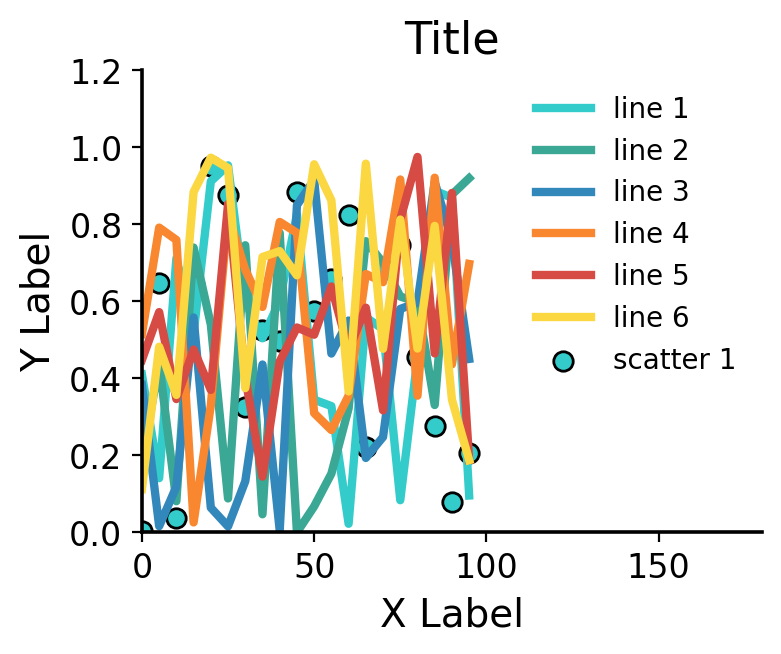

In [8]:
# Matplotlib figure configurations optimized for publications

colors = cycler('color',
                ['#34cccb', '#3AA894', '#3388BB', '#F98730',
                 '#D64B43', '#FBD741'])
paramvals = {
    'axes.prop_cycle': colors,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.titlesize': 16,
    'lines.linewidth': 3,
    'lines.markersize': 7,
    'scatter.edgecolors': 'black',
    'axes.linewidth': 1.3,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'sans-serif',
    'text.usetex': False,
    'legend.frameon': False,
    'figure.figsize': (4,3),
    'figure.dpi': 100,
}
for param, val in paramvals.items():
  mpl.rcParams[param] = val

# Show example figure
xs = np.arange(0, 100, 5)
plt.plot(xs, np.random.rand(len(xs)), label = 'line 1')
plt.plot(xs, np.random.rand(len(xs)), label = 'line 2')
plt.plot(xs, np.random.rand(len(xs)), label = 'line 3')
plt.plot(xs, np.random.rand(len(xs)), label = 'line 4')
plt.plot(xs, np.random.rand(len(xs)), label = 'line 5')
plt.plot(xs, np.random.rand(len(xs)), label = 'line 6')
plt.scatter(xs, np.random.rand(len(xs)), label = 'scatter 1')
plt.legend()
plt.title('Title')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.ylim(0, 1.2)
plt.xlim(0, 180)

## Animation

In [9]:
def _compute_edge_visitation(traj, states=127):
  """ Compute the edge visitation count.
  Compute V where V_ij is the number of visits from i to j.
  Args:
    traj: list of states visited.
    states: total number of unique states.
  Returns:
    List[V_t], where V is the assymetric edge visitation matrix.
  """
  list_visits = [np.zeros((states, states))]
  for i, j in zip(traj[:-1], traj[1:]):
    V_t = np.copy(list_visits[-1])
    V_t[i, j] += 1
    list_visits.append(V_t)
  return list_visits


def _compute_dM(list_M):
  """ Compute L2 Norm of dM given list of Ms over all steps of learning.
  Args:
    M: list of M, the recurrent connection matrix.
  Returns:
    List[Norm(dM)]
  """
  list_norms = []
  for M_1, M_2 in zip(list_M[:-1], list_M[1:]):
    list_norms.append(np.linalg.norm(M_2 - M_1, ord = 'fro'))
  list_norms.append(list_norms[-1]) # ensure len = number of steps.
  return list_norms


def animate_learning_plots(traj, adj_mat, M_data, T_data, 
                           goal_cell_map, goal_names, nonlinear=False,
                           n_states=None, n_frames=20, activation=None,
                           power=0.15):
  """ Use matplotlib functional animation module to show learning progression.
  Args:
    traj: trajectory of learning. Used to plot adjacency visitation matrix.
    adj_mat: adjacency matrix (0 or 1 to indicate connectivity).
    M_data: list of recurrent weights.
    T_data: list of associative learnin weights.
    goal_cell_map: Dict of states (keys) mapped to goal cell idx (vals).
    goal_names: names of goal cells for visualization.
    n_states: total number of states. if None, assume max(traj).
    n_frames: how many total frames to animate to show learning progression.
  Returns:
    Animation obj, which when called, produces animation.
  """
  if n_states is None:
    n_states = max(traj)
  edge_visits = _compute_edge_visitation(traj, states = n_states)
  list_dM_norms = _compute_dM(M_data)
  D = Floyd(adj_mat)
  def frame(frame):
    for ax in axs.flatten(): ax.clear()
    step = frame * (len(M_data) // n_frames)
    # Visitation Matrix (Connectivity)
    cm = axs[0,0].pcolormesh(edge_visits[step], 
                            cmap = 'Blues',
                            vmin = 0, vmax = 1)
    axs[0,0].set_title('Edge Visited')
    axs[0,0].set_xlabel('To')
    axs[0,0].set_ylabel('From')
    # dM
    axs[1,0].plot(list_dM_norms[:step])
    axs[1,0].set_xlim(0, len(list_dM_norms))
    axs[1,0].set_ylim(0, max(list_dM_norms) + 0.2 * max(list_dM_norms))
    axs[1,0].set_xlabel('Step')
    axs[1,0].set_ylabel('$\|\|dM\|\|$')
    axs[1,0].set_title('Recurrent Weights Change')
    # Map Cells
    if nonlinear:
      Y = get_nonlin_mapc_resps_all_locs(M_data[step], power)
    else:
      Y = get_linear_mapc_resps_all_locs(M_data[step], activation)
    plot_mapcell_monoton(D, Y, yscale='linear', ax = axs[0, 1])
    plot_mapcell_monoton(D, Y, yscale='log', ax = axs[1, 1])
    axs[0,1].set_title('Map Cells')
    # Goal Cells
    goal_resp = get_goalc_resps_all_locs(
      M_data[step],
      T_data[step],
      goal_cell_map)
    plot_goalcell_monoton(
        D,
        goal_resp,
        goal_cell_map,
        goal_names,
        yscale = 'log',
        goal_loc_add = 1,
        axs = [axs[1,2], axs[1,3]])
    plot_goalcell_monoton(
        D,
        goal_resp,
        goal_cell_map,
        goal_names,
        yscale = 'linear',
        goal_loc_add = 1,
        axs = [axs[0,2], axs[0,3]])
    for i in range(1,4):
      axs[1, i].set_title(None)
    for i in range(2, 4):
      axs[0, i].set_xlabel(None)
    fig.suptitle(f'Step: {step + 1}', size = 17)
    plt.subplots_adjust(top=0.87)
  # Create animation
  fig, axs = plt.subplots(figsize=(12, 7), 
                          nrows = 2, ncols = 4)
  return animation.FuncAnimation(
      fig, frame, frames = n_frames,
      blit = False, repeat = True)

## Generate Graphs

Alternative graphs based on specified or random mazes. Can specify constraints (e.g. number of loops).

In [10]:
def generate_random_graph(n, e, seed=None):
  '''
  Generate a random, undirected, connected graph.
  Args:
    n: number of nodes
    e: number of edges >= n
    s: random seed
  Returns:
    The adjacency matrix
  '''
  if seed is not None:
    np.random.seed(seed)
  ad = np.zeros((n, n)) - np.eye(n) # -1s on the diagonal, mark these edges as not allowed
  ad[0, 1] = 1; ad[1, 0] = 1 # start with 2 connected nodes
  for i in range(2, n): # add nodes by making a random connection to an existing node
    c = np.random.randint(0, i)
    ad[c, i] = 1; ad[i, c] = 1
  for i in range(n, e): # add edges by making a random connection that doesn't exist yet
    av = np.where(ad == 0) # available connections
    j = np.random.randint(0, len(av)) # pick one of these at random
    c = av[0][j]; d = av[1][j] # find the corresponding nodes
    ad[c, d] = 1; ad[d, c] = 1 # make the connection
  return ad + np.eye(n) # return adjacency matrix, make diagonal zero again


def plot_graph_from_adj(adj, directed=False, mode='normal',
                        node_size=200, font_size=10):
  """ Plot a graph in matplotlib given adjacency matrix.
  Args:
    adj: adjacency matrix.
    directed: whether plotted graph is directed or not.
    mode: type of plot. Can be normal, circular.
    node_size: size of nodes in visuals.
    font_size: size of the node label font.
  Returns:
    matplotlib plot obj.
  """
  if directed:
    G = nx.DiGraph()
  else:
    G = nx.Graph()
  for i in range(adj.shape[0]): 
    for j in range(adj.shape[1]): 
      if adj[i][j] == 1: 
          G.add_edge(i, j)
  if mode == 'normal':
    return nx.draw(G, with_labels = True, node_size = node_size, 
            font_size = font_size, font_color = 'white')
  elif mode == 'circular':
    return nx.draw_circular(G, with_labels = True)


def create_hanoi_graph(n):
    '''
    Finds all the states and their adjacency matrix for the Tower of Hanoi with n disks.
    Returns: 
    s = a list of states, each is a list containing the stack for each of the 3 posts.
    The disks are numbered 0,...,n-1.
    c = a sparse connectivity matrix among those states, given as a list of pairs [i,j]
    for all the connected states, where i and j are indices into s.
    '''
    st=[list(range(n)),[],[]] # initialize starting state
    s=[st] # initialize list of all states
    c=set() # initialize set of connections
    k=0 # index of state currently being considered
    while k < len(s): # check if there are more states to handle
        st=s[k] # current state
        for i in range(3): # try moving a ring from each post i
            if len(st[i])>0: # if there is a ring
                x=st[i][0] # top ring on post i
                for j in range(3): # consider each of the other posts
                    if j!=i: # other posts j
                        if len(st[j])==0 or x<st[j][0]: # if x is smaller than top ring on j
                            sta=st.copy() # move the ring 
                            sta[i]=st[i][1:] # from post i
                            sta[j]=[x]+st[j] # to post j
                            if sta in s: # have already found this state
                                c.add(tuple([k,s.index(sta)])) # add to set of edges
                            else: # if this is a new state
                                s+=[sta] # add to list of states
                                c.add(tuple([k,len(s)-1])) # add to set of edges
        k+=1 # done with this state
    return s,c

## Random Walk Simulator

In [11]:
def graph_randomwalk(adj_mat, start_node=None, steps=1000):
  """ Generate random walk based on arbitrary adjacency matrix.
  Args:
    adj_mat: adjacency matrix where the ij-th entry is the 
    connectivity from i to j states. Must be 1 or 0.
    start_node: either None which means random or specify node number (int)
    Non-stationarity:
    If adj_mat and steps are both lists of the same length,
    then the walk will first use the first adj_mat for steps[0], etc.
    Note: this assumes that we're not closing off any nodes, as otherwise
    the agent could get trapped in a island node is it happens to be the last
    node it visited using a previously open adj_mat.
  Returns:
    List[states]
  """
  if not isinstance(adj_mat, list): # stationary environment
    adj_mat = [adj_mat]
    steps = [int(steps)]
  assert len(adj_mat) == len(steps)
  if start_node is None:
    start_node = int(np.random.choice(len(adj_mat[0])))
  states = [start_node]
  steps[0] -= 1
  for adj_mat_i, tot_steps_i in zip(adj_mat, steps):
    for _ in range(tot_steps_i):
      s_t = states[-1]
      options = list(np.where(adj_mat_i[s_t])[0])
      if len(options) == 0:
        options.append(s_t)
      next_s = int(np.random.choice(options))
      states.append(next_s)
  return states


def maze_randomwalk(steps: int,
                    random_seed: int,
                    mode='node') -> np.ndarray:
  """ Generate synthetic data
  Wraps around Markus's code.
  Args:
    steps: number of steps for random walk
    mode: select cell or node
  Returns:
    List[nodes]
  """
  Traj = MakeRandomWalk(NewMaze(6),
                        n = steps,
                        rs = random_seed)
  if mode == 'node':
    return Traj.no[0][:-1, 0]
  elif mode == 'cell':
    return Traj.ce
  return rw

## Models

In [12]:
def _logger(traj, weights, cells, log, 
            experiment_tag, save_log=None, save_every=1000):
  """ Log weights and cell activities for one learning step.
  Args:
    traj: list of state visites
    log: dictionary of log records. If None, initialize.
    weights: dictionary of weights.
    cells: dictionary of cell records (vectors).
    save_log: None or directory to dump log to.
    save_every: number of iterations before saving (pickling is slow)
  Returns:
    Updated log file.
  """
  if log is None:
    log = {'traj': traj, 'weights': {}, 'cells': {}}
  for w_name, w in weights.items():
    if w_name not in log['weights']:
      log['weights'][w_name] = []
    log['weights'][w_name].append(w)
  for c_name, c in cells.items():
    if c_name not in log['cells']:
      log['cells'][c_name] = []
    log['cells'][c_name].append(c)
  logged_steps = len(log['weights']['M'])
  if save_log is not None:
    if logged_steps % save_every == 0 or logged_steps == len(traj):
      _pickle_save(log, save_log, experiment_tag)
  return log


def load_logs(dir, row_saved, col_saved, row_val, col_val, trajs,
              prefix='hanoi4_oja'):
  logs = []
  for run, traj in enumerate(trajs):
    path = f'{dir}/{prefix}_{row_saved}{row_val}-{col_saved}{col_val}-run{run}.p'
    log = pickle.load(open(path, 'rb'))
    log['traj'] = traj[::x_interval]
    for w_name, w_vals in log['weights'].items():
      if len(w_vals) < len(traj):
        concat = [w_vals[-1] for _ in range(len(traj) - len(w_vals))]
        log['weights'][w_name] = w_vals + concat
    logs.append(log)
  return logs

def fill_logs(all_logs):
  for nb, logs in enumerate(all_logs):
    for run_nb, log in enumerate(logs):
      for w_name, w_vals in log['weights'].items():
        if len(w_vals) < len(log['traj']):
          concat = [w_vals[-1] for _ in range(len(log['traj']) - len(w_vals))]
          w_vals += concat
  return all_logs


def _initialize_weights(n_states=127, n_goals=3, w_init=0):
  """ Initialize all weights (W, M, T)
  Args:
    n_states: number of states
    n_goals: number of goals
  Returns:
    M: recurrent, plastic, from all-to-all between map cells.
    G: feedforward, plastic, from map cells to goal cells.
  """
  M = np.full((n_states, n_states), w_init, dtype = 'float64')
  G = np.full((n_goals, n_states), w_init, dtype = 'float64')
  return M, G


def _placecell_resp(traj, t, n_states, activity=1, decay=0.5,
                    spatial=True, adj_mat=None, active_range=1):
  """ Get place cell responses based on recent visited states.
  This a simple way to learn correlations. It can be thought of as a
  time constant.
  Args:
    traj: entire trajectory of experience
    t: current state index (timestep)
    n_states: total number of states (determines number of cells)
    activity: what to set the current place cell's activity to
    decay: discount factor at each step away from state_t. 1 = no decay.
    spatial: set all neighboring nodes active
    adj_mat: for spatial mode need adj_mat of the graph to work.
    active_range: how many previous place cells in time to keep active.
  Returns:
    vector of place cell activity for all place cells.
  """
  response = np.zeros((n_states, 1))
  response[traj[t]] = activity
  if spatial:
    adj_nodes = np.where(adj_mat[traj[t]])[0]
    for node in adj_nodes:
      if node != traj[t]:
        response[node] = activity * decay
  else:
    for stepback in range(t, max(-1, t - active_range - 1), -1):
      response[traj[stepback]] = activity
      activity *= decay
  return response


def _navigate_odor_steps(adj_mat, odor_resp, origin_state, dest_state):
  """ Use odor response for navigation from given origin state to destination,
  count number of steps taken. If stuck, return inf.
  Exception: if current node has higher odor gradient than all adjacent, 
  stay in current node.
  Args:
    adj_mat: adjacency matrix of the environment.
    odor_resp: odor response vector for one goal neuron.
    origin_state: where to start navigation from.
    dest_state: destination state(s). If multiple, take shorter path one as gt.
  Return:
    steps, the number of steps taken. if upperbound reached, return inf.
  """
  steps = 0
  curr_state = origin_state
  max_steps = len(adj_mat)
  if curr_state == dest_state:
    return steps
  while steps < max_steps and curr_state != dest_state:
    next_states = np.where(adj_mat[curr_state])[0]
    if np.sum(odor_resp[next_states]) != 0:
      current_odor = odor_resp[curr_state]
      adj_mat_odor = np.max(odor_resp[next_states])
      if adj_mat_odor >= current_odor:
        curr_state = next_states[np.argmax(odor_resp[next_states])]
    steps += 1
  if curr_state == dest_state:
    return steps
  else:
    return np.inf


def _navigatable_ratemodel(adj_mat, goal_resp, goal_states, multiloc=False):
  """ Test if a goal neuron allows sufficient navigation from all locations.
  Args:
    adj_matrix: connectivity of the env, used to compute D, shortest paths.
    goal_resp: P x G response matrix of all goal neurons (G) responses 
    to all place cell locations (P).
    goal_states: matching goal states of each goal neuron.
    multiloc: whether all goal states correspond to the same neuron.
  Returns:
    G * P * 2 matrix, where G is the goal, P is each location of origination,
    and the last dimension used for ground truth and model path length.
    They should match if it's navigatable via shortest path.
  """
  D = Floyd(adj_mat)
  if len(goal_states) != goal_resp.shape[1] and multiloc is False:
    raise ValueError('Number of goals in goal_states does not match responses.')
  n_goals = goal_resp.shape[1]
  n_places = adj_mat.shape[0]
  output = np.zeros((n_goals, n_places, 2))
  if multiloc: goal_states = [goal_states] # combine into one goal neuron
  for goal_idx, goal_state in enumerate(goal_states):
    for start_state in range(n_places):
      output[goal_idx, start_state, 0] = D[goal_state, start_state]
      output[goal_idx, start_state, 1] = _navigate_odor_steps(adj_mat, 
                                                    goal_resp[:, goal_idx], 
                                                    start_state,
                                                    goal_state)
  return output


def _goalcell_sensoryinput(node_t, n_goalcells, goal_cell_map, activity):
  """ Get sensory input to goal cell if current location is a goal.
  Args:
    node_t: current node of the simulated mouse.
    n_goalcells: number of goal cells. Critical when there are more
    goal cells than actual goal nodes during non-stationary learning.
    goal_cell_map: which goal state map to which goal cell number
    activity: Dict of activities (values) for each goal node (keys)
  Returns:
    vector of goal cell activity for all goal cells.
  """
  response = np.zeros((n_goalcells, 1))
  if node_t in goal_cell_map:
    response[goal_cell_map[node_t]] = activity[node_t]
  return response


def _activation(pre_act_resp, activation=None):
  """ Apply nonlinear activation transform on responses.
  Args:
    pre_act_resp: List[cell response (vector) pre-activation
    activation: None, or one of listed str options, or a function to be called.
  Returns:
    Cell responses with activation applied.
  """
  if isinstance(pre_act_resp, list):
    pre_act_resp = np.array(pre_act_resp)
  if activation is None:
    return pre_act_resp
  elif activation == 'sigmoid':
    return jax.nn.sigmoid(pre_act_resp)
  elif activation == 'log':
    return np.log(pre_act_resp)
  elif activation == 'power':
    mask = (pre_act_resp > 0)
    d = np.empty_like(pre_act_resp)
    d[mask] = pre_act_resp[mask] ** 0.15
    d[~mask] = 0
    return d
  else:
    return activation(pre_act_resp)


def get_linear_mapc_resps_all_locs(M, activation=None):
  """ Get all map cell responses at all states
  Args:
    M: recurrent connections amongst place cells.
  Returns:
    Map cell responses for each place cell location (N x N matrix).
  """
  resp = jax.numpy.linalg.inv(np.eye(M.shape[0]) - M)
  resp = _activation(resp, activation)
  return resp


def get_goalc_resps_all_locs(M, G, goal_cell_map, sensory_input=1,
                             same_goal_cell=False, spatial=True,
                             adj_mat=None, u_active=1, decay=0.3):
  """ Get the goal cell's response to all place cell inputs
  Args:
    M: recurrent connections amongst place cells.
    G: feedforward connections from map to goal cells.
    goal_cell_map: list[goal locations]
    same_goal_cell: ring task where all goals connect to same goal cell. 
    sensory_input: at goal location, add this value (sensory)
    spatial: activate place fields from neighboring place fields
  Returns:
    Map cell responses for each place cell location.
  """
  if not isinstance(sensory_input, dict):
    sensory_input = {g_loc: sensory_input for g_loc in goal_cell_map}
  K = jax.numpy.linalg.inv(np.eye(M.shape[0]) - M)
  if spatial:
    n_nodes = M.shape[0]
    map_resp_spat = []
    for node in range(n_nodes):
      p_activ = np.zeros((n_nodes, 1))
      p_activ[node] = u_active
      adj_nodes = np.where(adj_mat[node])[0]
      for adj_n in adj_nodes:
        if adj_n != node:
          p_activ[adj_n] = u_active * decay
      map_resp_spat.append(jax.numpy.matmul(K, p_activ).flatten())
    map_resp = np.array(map_resp_spat)  
  goal_resp = np.array(jax.numpy.matmul(map_resp, G.T))
  for goal_nb, goal_state in enumerate(goal_cell_map):
    if same_goal_cell:
      goal_nb = 0
    goal_resp[goal_state, goal_nb] += sensory_input[goal_state]
  return goal_resp


def get_maze_node_dists(levels=6):
  """ Get distance matrix for binary maze of given levels.
  Args:
    levels: number of levels to the binary tree maze.
  Returns:
    distance matrix of N x N, where N_ij is the distance
    between node_i and node_j.
  """
  return Floyd(BinaryMaze(6))


def _add_gauss_noise(resp, sd_frac, lognormal=False):
  """ Add gaussian noise to cell responses, which are means.
  Args:
    resp: responses of the cell
    sd: fraction of each response to set as the standard deviation. 0<=sd<=1
  """
  output = np.zeros(resp.shape)
  for idx, val in np.ndenumerate(resp):
    if lognormal:
      abs_sd = np.abs(val * sd_frac)
    else:
      abs_sd = np.abs(val * sd_frac)
    output[idx] = _samp_gauss(val, abs_sd, lognormal = lognormal)
  return output


def _samp_gauss(mean, sd, size=1, floor=0, lognormal=False):
  # draw a sample from a Gaussian with mean and var.
  if lognormal:
    if mean == 0:
      samps = np.zeros(size)
    else:
      samps = np.random.lognormal(np.log(mean), sd, size)
  else:
    samps = np.random.normal(mean, sd, size)
    samps = np.clip(samps, 0, None)
  return samps


def simulate_learning(
    trajectory, n_states, alpha=0.05, beta=0.02,
    n_goals=3, log_data=True, save_log=None, goal_cell_map={}, 
    experiment_tag='', activation=None, switch_graph=[0], 
    G_beta=0.3, G_alpha_scale=0.5, place_activity=1, place_decay=0.3, 
    weight_decay=True, goal_input_eff=1, noise_sd_frac=0, 
    goal_corr_steps=None, noise_lognormal=False, adj_mat=None):
  """ Learning simplified with weight normalization and LTD.
  LTD: implemented by decaying all neurons that connect to the pre-synaptic
  map cell firing, that aren't driven to fire by the point cell.
  Can be subtractive or divisive.
  Args:
    trajectory: list of visited states (nodes in graph).
    n_states: number of total states in environment.
    n_goals: number of goal cells for simulation.
    log_data: log all weights and activities at each step.
    goal_cell_map: dictionary of pairs of goals node (keys) and 
    goal cell (vals).
    alpha: from Oja's Rule.
    beta: from Oja's Rule.
    place_decay: w from paper. Controls activity of adjacent point cells.
    weight_decay: whether to allow natural weight decay in Oja's Rule.
    goal_corr_steps: for graph where the goal config changes, pass list of
    steps at which a new config is loaded. For instance, is the configs are 
    1, 2 each occupying 1/5 the time, the corresponding goal_cor_steps would be
    [0, len(trajectory)//2].
    goal_input_eff: scalar value of sensory inputs at each goal node. If Dict,
    maps each goal (key) to a unique sensory input (val). Must have entries for
    all goal locations. signal map is required.
    noise_sd_frac: SD computed as a fraction of the mean of each neuron.
    Gaussian noise injected to each neuron to test learning robustness.
    experiment_tag: prefix of name for saved data.
    activation: apply a transform function on top of cell responses.
    adj_mat: necessary for neighboring spatial place fields for point cells.
  Returns:
    log (type: Dict) with history of all weights and cell activities.
  """
  tag = f'{_get_timestr()}_{experiment_tag}'
  M, G = _initialize_weights(n_states, n_goals) #_ij = synapse from j to i
  if log_data: log = None
  if goal_corr_steps is None: # stationary env
    goal_corr_steps = [0, len(trajectory)]
    goal_cell_map = [goal_cell_map]
  goal_config_idx = 0
  if goal_corr_steps[-1] != len(trajectory):
    goal_corr_steps.append(len(trajectory))
  # set efference
  if isinstance(goal_input_eff, list):
    efference = 'custom'
  elif isinstance(goal_input_eff, dict):
    efference = 'custom'
    goal_input_eff = [goal_input_eff]
  else:
    efference = 'default'
    goal_input_eff = [goal_input_eff]
  if np.array(adj_mat).ndim == 2:
    adj_mat = [adj_mat]
  switch_graph = np.array(switch_graph)
  # Starting learning loop
  for t, state in enumerate(trajectory):
    # determine goal config config
    if t >= goal_corr_steps[goal_config_idx + 1]:
      goal_config_idx += 1
    env_config_nb = np.where(t >= switch_graph)[0][-1]
    goal_cell_map_t = goal_cell_map[goal_config_idx]
    goal_input_eff_t = goal_input_eff[goal_config_idx]
    if efference == 'default':
      goal_input_eff_t = {g_loc: goal_input_eff_t for g_loc in goal_cell_map_t}
    progress_bar(t, len(trajectory))
    ## FORWARD PASS
    place_c = _placecell_resp(trajectory, t, n_states,
                              activity = place_activity, decay = place_decay,
                              spatial = True, adj_mat = adj_mat[env_config_nb])
    sensory = _goalcell_sensoryinput(state, n_goals, goal_cell_map_t,
                                    activity = goal_input_eff_t)
    place_c = _add_gauss_noise(place_c, noise_sd_frac, 
                               lognormal = noise_lognormal)
    K = jax.numpy.linalg.inv(np.eye(n_states) - M)
    map_c = jax.numpy.matmul(K, place_c)
    map_c = _add_gauss_noise(map_c, noise_sd_frac, 
                             lognormal = noise_lognormal)
    goal_c = sensory + jax.numpy.matmul(G, map_c)
    goal_c = _add_gauss_noise(goal_c, noise_sd_frac, 
                              lognormal = noise_lognormal)
    ## Compute Gradients
    # dM
    hebb_map = np.array(jax.numpy.matmul(map_c, map_c.T))
    dM = beta * (alpha * hebb_map - M * map_c ** 2) # map_c: col-vec
    if not weight_decay:
      dM = np.clip(dM, 0, None) # Only strengthening
    dM = np.array(dM)
    # dT
    hebb_goal = jax.numpy.matmul(goal_c, map_c.T)
    G_alpha = G_alpha_scale * alpha
    dG = G_beta * (G_alpha * hebb_goal - G * goal_c ** 2) # goal_c: col-vec
    if not weight_decay:
      dG = np.clip(dG, 0, None) # Only strengthening
    # Warnings
    if np.isnan(M).any():
      warnings.warn(f'Nan detected in weight matrix M.')
      return log
    elif np.isnan(G).any():
      warnings.warn(f'Nan detected in weight matrix T.')
      return log
    # Update weights
    M = M + dM
    G = G + dG
    M = np.where(M < 0, 0, M)
    G = np.where(G < 0, 0, G)
    np.fill_diagonal(M, 0)
    # Log data
    if log_data:
      log = _logger(traj = trajectory, 
                    weights = {'M': M, 'G': G},
                    cells = {'Place': place_c, 'Map': map_c, 'Goal': goal_c},
                    log = log, experiment_tag = tag, save_log = save_log)
  return log

# Simulations

## Gridworld Snapshots

|█                        | 7%

|█████████████████████████| 100%
Goal [8] not navigatable: 2
from [0 6]
Goal [3] not navigatable: 2
from [0 6]
Goal [11] not navigatable: 2
from [0 6]


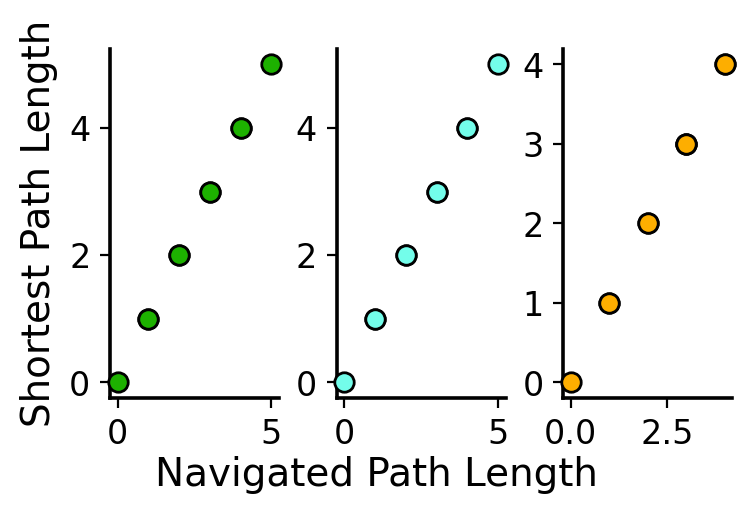

In [18]:
# Gridworld Example

adj_mat = np.zeros((12,12))
pairs = [(1,2), (1,5), (2,3), (3,7), (7,11), (11,10), 
         (10,9), (9,8), (9,5), (4,8), (4,5)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1

traj = [8,4,5,9,8,9,5,1,2,3,7,11,10,9] # specified

log = simulate_learning(
    traj,
    n_states = len(adj_mat),
    goal_cell_map ={8: 0, 3: 1, 11: 2}, # home, water, food
    n_goals = 3,
    adj_mat = adj_mat,
    )

goal_resps = []
for ts, (M, G) in enumerate(zip(log['weights']['M'], log['weights']['G'])):
  goal_resps.append(get_goalc_resps_all_locs(
        M, G, [8, 3, 11], adj_mat=adj_mat))
goal_resps = np.array(goal_resps)
# Plot navigatability
print()
plot_modelsteps_v_actualsteps(log, adj_mat, 
                              [8, 3, 11], 
                              ['#1DB100', '#73FDEA', '#FDAE00'],
                              figsize = (3.7,2.3))

(-1.0, 25.0, 11.100000000000001, -1.0)

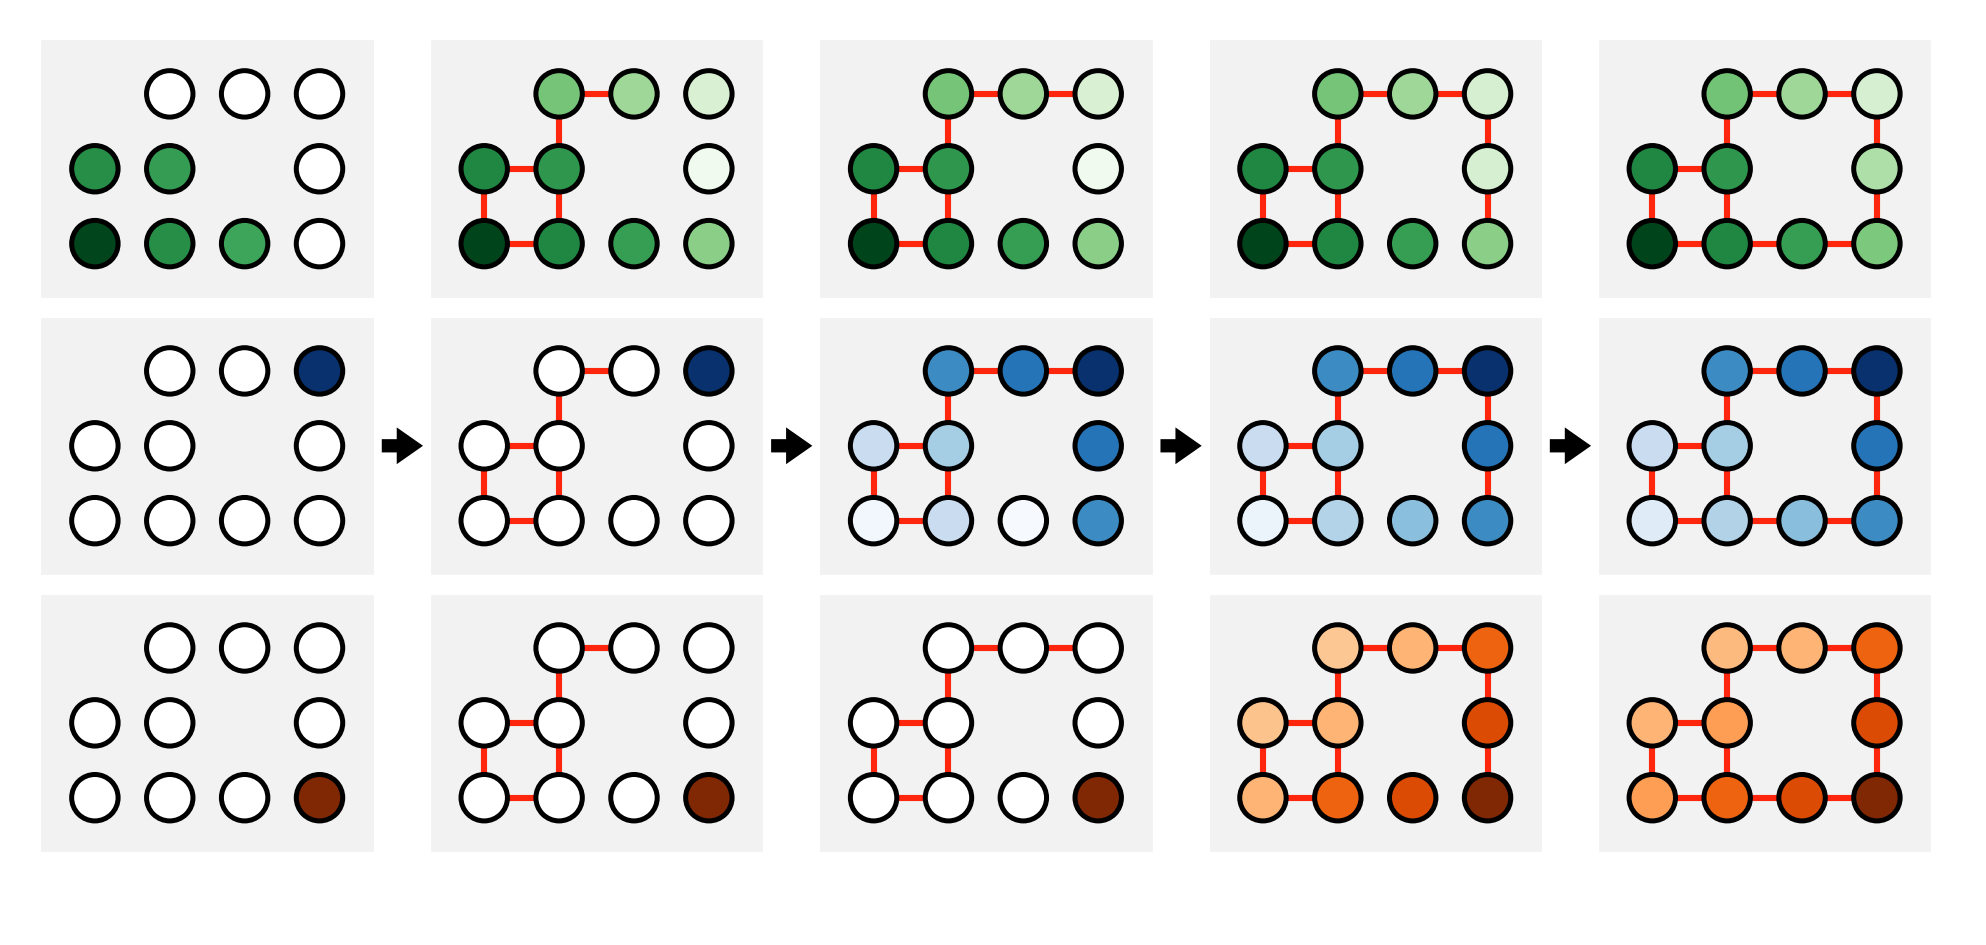

In [ ]:
## Generate snapshot plot

def get_edges(traj, undirected=True):
  edges = set()
  for n1, n2 in zip(traj[:-1], traj[1:]):
    if not undirected and (n1, n2) not in edges:
      edges.add((n1,n2))
    elif (n2, n1) not in edges and (n1, n2) not in edges:
      edges.add((n1,n2))
  return edges

# Plot
timesteps = [0, 8, 9, 11, -1]
n_goals = 3

fig, ax = plt.subplots(figsize = (3 * len(timesteps), n_goals * 2))
ax.set_aspect('equal')
ax.set_xlim(-1, 5.2 * len(timesteps)-1)
ax.set_ylim(-1, 3.7 * n_goals)
ax.invert_yaxis()

cmaps = [mpl.cm.get_cmap(cmap) for cmap in ['Greens', 'Blues', 'Oranges']]

for nb, t in enumerate(timesteps):
  if t == -1:
    subtraj = traj
  else:
    subtraj = traj[:t+1]
  edges = get_edges(subtraj)
  for goal in range(n_goals):
    x_edge = 5.2 * nb
    y_edge = 3.7 * goal
    # plot gray background
    bg = mpl.patches.Rectangle((x_edge - 0.7, y_edge - 0.7), 4.4, 3.4,
                               zorder = 0, color = '0.95')
    ax.add_patch(bg)
    # plot edges
    for n1, n2 in edges:
      x1 = n1 % 4 + x_edge
      y1 = n1 // 4 + y_edge
      x2 = n2 % 4 + x_edge
      y2 = n2 // 4 + y_edge
      plt.plot([x1, x2], [y1, y2], color = '#FF260E', zorder=5, lw = 2.2)
    # plot circles
    for node_nb in [1,2,3,4,5,7,8,9,10,11]:
      x = node_nb % 4 + x_edge
      y = node_nb // 4 + y_edge
      vmax = 1.1
      vmin = 1e-9
      norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
      if goal_resps[t, node_nb, goal] == 0:
        color = 'white'
      else:
        color = cmaps[goal](norm(goal_resps[t, node_nb, goal]))
      node = mpl.patches.Circle((x, y), 0.31, facecolor=color,
                                edgecolor='black', lw=1.8, zorder=10)
      ax.add_patch(node)
    # plot arrows
    if goal == 1 and nb < 4:
      arrow = mpl.patches.FancyArrow(x_edge+3.85, y_edge+1, 0.2, 0, 
                                     width = 0.14, head_length=0.3,
                                     zorder = 15, color = 'black')
      ax.add_patch(arrow)

ax.axis('off')
# plt.savefig(f'sim_logs/gridworld_sim_goalcolored_graph.pdf')

## Task Generality

### Gridworld

In [14]:
# Create graph
adj_mat = np.zeros((10,10))
pairs = [(0,1), (0,4), (1,2), (2,5), (3,4), (5,9), 
         (6,7), (6,3), (7,4), (7,8), (8,9)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1
# Simulate random walk
traj = pickle.load(open('sim_logs/gridworld_traj.p', 'rb'))
# Train model (high u_active)
log = simulate_learning(
    traj,
    n_states = len(adj_mat),
    goal_cell_map = {6: 0, 2: 1, 9: 2}, # home, water, food
    n_goals = 3,
    adj_mat = adj_mat,
    )

|█████████████████████████| 100%

Goal [6] not navigatable: 0
from []
Goal [2] not navigatable: 0
from []
Goal [9] not navigatable: 0
from []


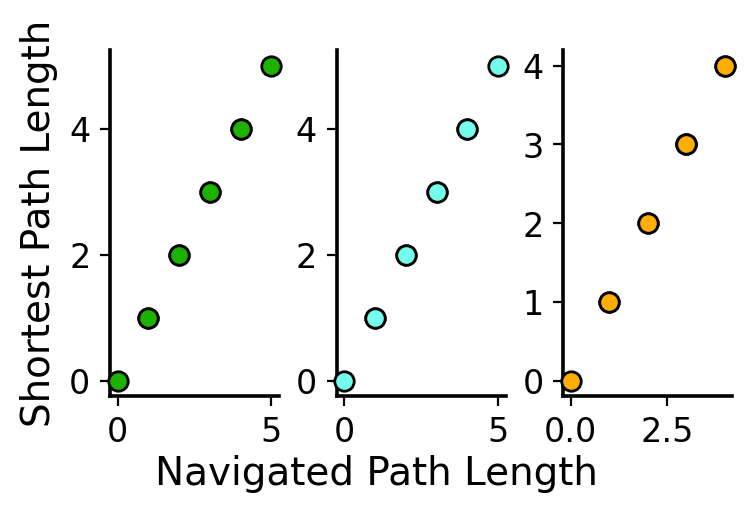

In [ ]:
plot_modelsteps_v_actualsteps(log, adj_mat, 
                              [6, 2, 9], 
                              ['#1DB100', '#73FDEA', '#FDAE00'],
                              figsize = (3.7,2.3))
# plt.savefig('sim_logs/gridworld_steps.pdf',
#             bbox_inches="tight")

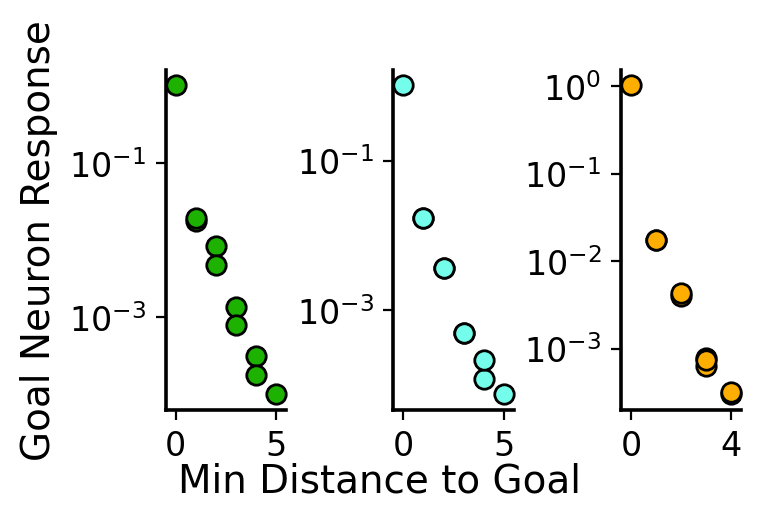

In [ ]:
M = log['weights']['M'][-1]
G = log['weights']['G'][-1]
D = Floyd(adj_mat)
goal_resp = get_goalc_resps_all_locs(M, G, {6: 0, 2: 1, 9: 2}, 
                                     sensory_input = 1,
                                     adj_mat = adj_mat)
gt = plot_goalcell_monoton(D,
                           goal_resp,
                           goal_cell_map = {6: 0, 2: 1, 9: 2},
                           goal_names = ['Home', 'Water', 'Food'],
                           goal_colors = ['#1DB100', '#73FDEA', '#FDAE00'],
                           goal_loc_add = 0,
                           figsize = (3.7,2.3))
plt.xticks([0, 4], [0, 4])
plt.savefig('sim_logs/gridworld_goalresponse.pdf',
            bbox_inches="tight")

### Binary Tree Maze

|█████████████████████████| 100%

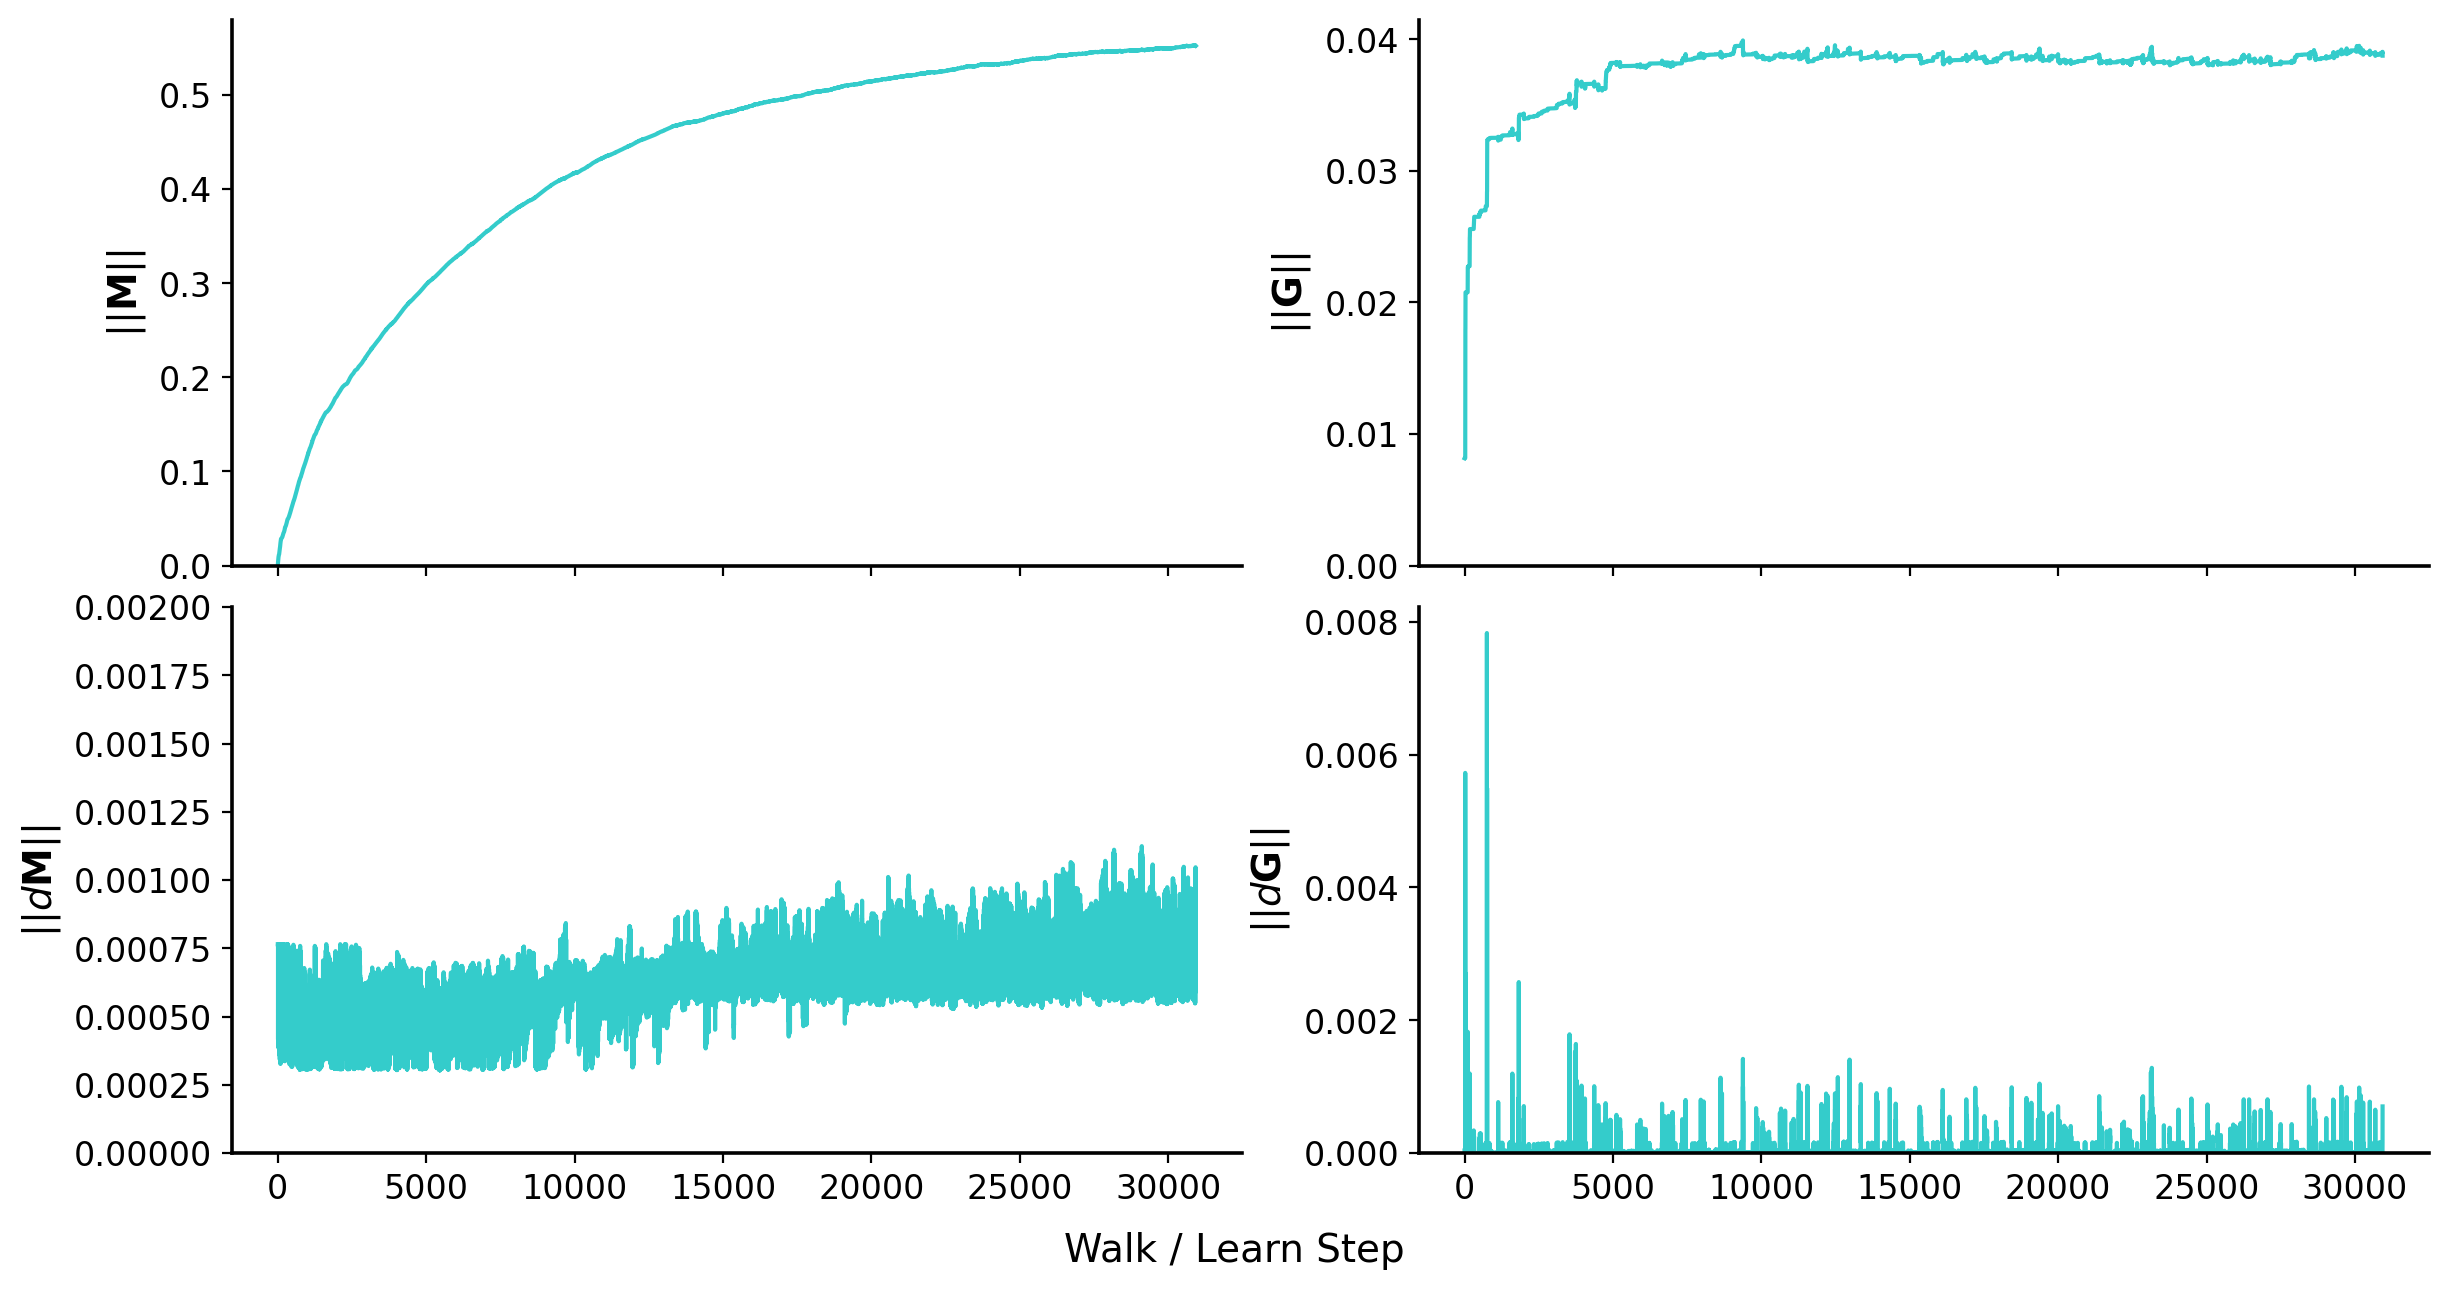

In [ ]:
# Simulate random walk
traj = pickle.load(open('sim_logs/binarytree_traj.p', 'rb'))
# Train model
log = simulate_learning(
    traj,
    n_states = 127,
    goal_cell_map = {0: 0, 116: 1},
    adj_mat = BinaryMaze(),
    n_goals = 2)
plot_learning_stability_curves_4panel(log)
plt.savefig('sim_logs/learning_stability_binarytree_4panel.pdf')

Goal [0] not navigatable: 0
from []
Goal [116] not navigatable: 0
from []


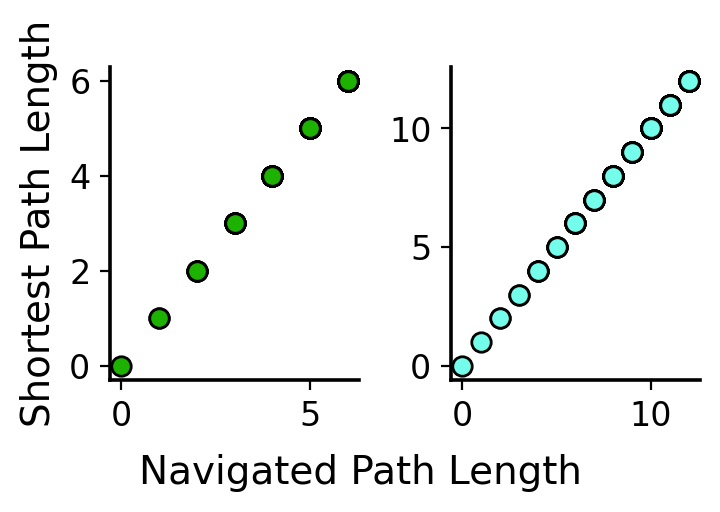

In [ ]:
plot_modelsteps_v_actualsteps(log, BinaryMaze(), 
                              [0, 116], 
                              ['#1DB100', '#73FDEA'],
                              figsize = (3.7, 2.3),
                              ts=-1)
plt.tight_layout()
# plt.savefig('sim_logs/binarytreetask_steps.pdf',
#             bbox_inches="tight")

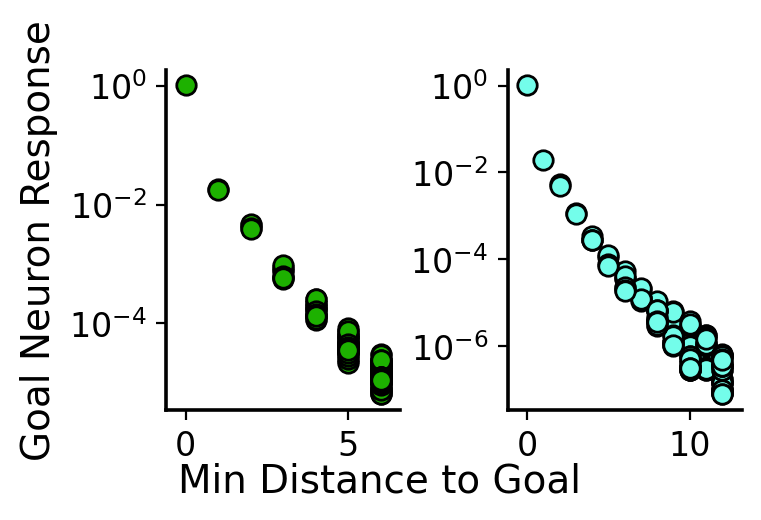

In [ ]:
# Plot goal cell response
M = log['weights']['M'][-1]
G = log['weights']['G'][-1]
D = Floyd(BinaryMaze())
goal_resp = get_goalc_resps_all_locs(M, G, {0: 0, 116: 1}, sensory_input=1,
                                     adj_mat = BinaryMaze())
gt = plot_goalcell_monoton(D,
                           goal_resp,
                           goal_cell_map = {0: 0, 116: 1},
                           goal_names = ['Home', 'Reward'],
                           goal_colors = ['#1DB100', '#73FDEA'],
                           goal_loc_add = 0,
                           figsize = (3.7,2.3))
plt.savefig('sim_logs/binarytreetask_goalresponse.pdf',
            bbox_inches="tight")

### Tower of Hanoi

In [ ]:
states, edges = create_hanoi_graph(4)
n_states = len(states)
adj_mat = np.zeros((n_states, n_states))
for n1, n2 in edges:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1
goal1 = states.index([[], [0,1,2,3], []])
goal2 = states.index([[], [], [0,1,2,3]])
# Generate Random Walk
traj = graph_randomwalk(adj_mat,
                        start_node = 0,
                        steps = 5e4)

traj = pickle.load(open('sim_logs/hanoi_traj.p', 'rb'))

# Train model
log = simulate_learning(
    traj,
    n_states,
    goal_cell_map = {goal1: 0, goal2: 1},
    adj_mat = adj_mat,
    n_goals = 2)

|                         | 0%

|█████████████████████████| 100%

Goal [80] not navigatable: 0
from []
Goal [70] not navigatable: 0
from []


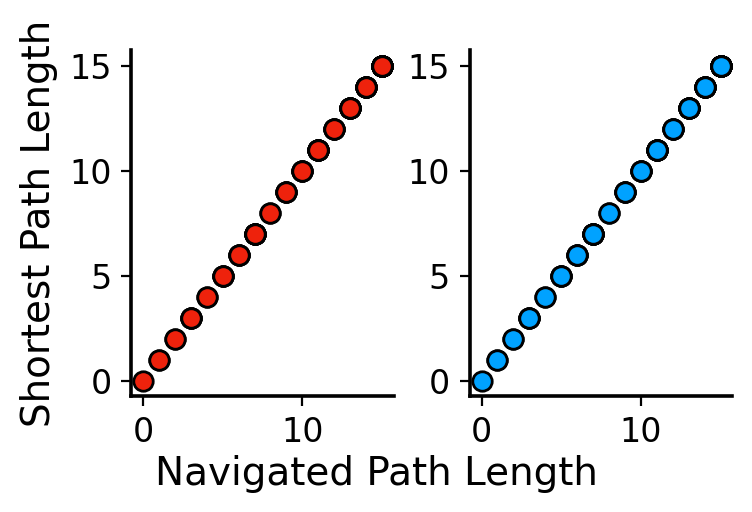

In [ ]:
plot_modelsteps_v_actualsteps(log, adj_mat, 
                              [goal1, goal2], 
                              ['#EE220C', '#00A2FF'],
                              figsize = (3.7,2.3),
                              ts = -1)
# plt.savefig('sim_logs/towerofhanoi4_steps.pdf',
#             bbox_inches='tight') 

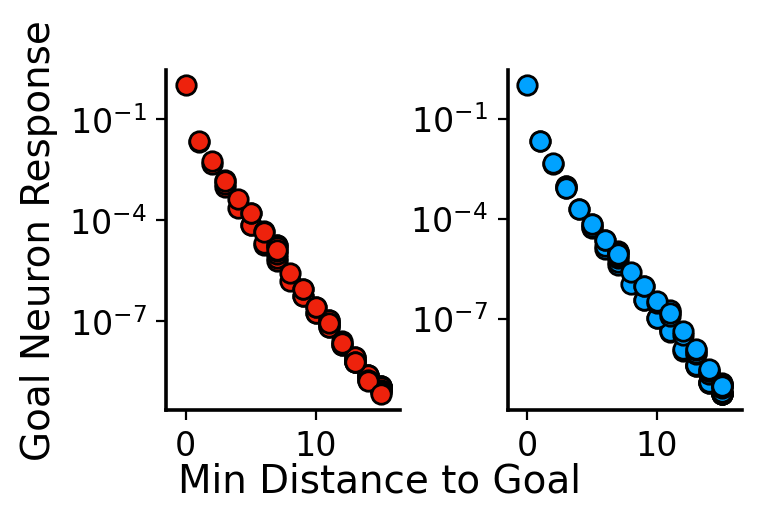

In [ ]:
# Plot goal cell response
M = log['weights']['M'][-1]
G = log['weights']['G'][-1]
D = Floyd(adj_mat)
goal_resp = get_goalc_resps_all_locs(M, G, {goal1: 0, goal2: 1}, 
                                     sensory_input = 1,
                                     decay=0.3,
                                     adj_mat=adj_mat)
gt = plot_goalcell_monoton(D,
                           goal_resp,
                           goal_cell_map = {goal1: 0, goal2: 1},
                           goal_names = ['Goal1', 'Goal2'],
                           goal_colors = ['#EE220C', '#00A2FF'],
                           goal_loc_add = 0,
                           figsize = (3.7,2.3))
plt.savefig('sim_logs/towerofhanoi4_goalresponse.pdf',
            bbox_inches = 'tight')

## Adaptation

### Blockage

Ring task where an edge is severed. When this happens, the point cells that once drove the severed map cells now no longer activate due to difference in stimuli. New point cells are recruited for each node, that form a new map connection.

In [ ]:
# Graph: build an adjacency matrix with n + 2 nodes,
# where the 2 extra nodes will be used after blockage has started.

# 1) start with ring with 10 connected nodes plus 2 unconnected
n_nodes = 10
add_nodes = 2
adj_mat1 = np.zeros((n_nodes + add_nodes, n_nodes + add_nodes))
pairs = [(i,i+1) for i in range(n_nodes-1)] + [(n_nodes-1, 0)]
for n1, n2 in pairs:
  adj_mat1[n1,n2] = adj_mat1[n2,n1] = 1
# 2) cut off connection between 2 and 3
adj_mat2 = np.copy(adj_mat1)
# remove dropped node connectivity
adj_mat2[1,2] = adj_mat2[2,1] = adj_mat2[3,4] = adj_mat2[4,3] = 0
# recruit new nodes that correspond to new point cells
adj_mat2[1,10] = adj_mat2[10,1] = adj_mat2[11,4] = adj_mat2[4,11] = 1
switch = 200
runs = 200
logs = []
for _ in range(runs):
  invalid_traj = True
  while invalid_traj:
    # Ensure walker didn't get stuck at nodes 2-3 when connection changes.
    traj = graph_randomwalk([adj_mat1, adj_mat2],
                            start_node = 0,
                            steps = [switch, 200])
    if 2 not in set(traj[switch:]):
      invalid_traj = False
  log = simulate_learning(
      traj,
      n_states = n_nodes + add_nodes,
      goal_cell_map = {0: 0}, # one goal
      n_goals = 1,
      switch_graph = [0, switch],
      adj_mat = [adj_mat1, adj_mat2]
      )
  logs.append(log)

|█████████████████████████| 100%

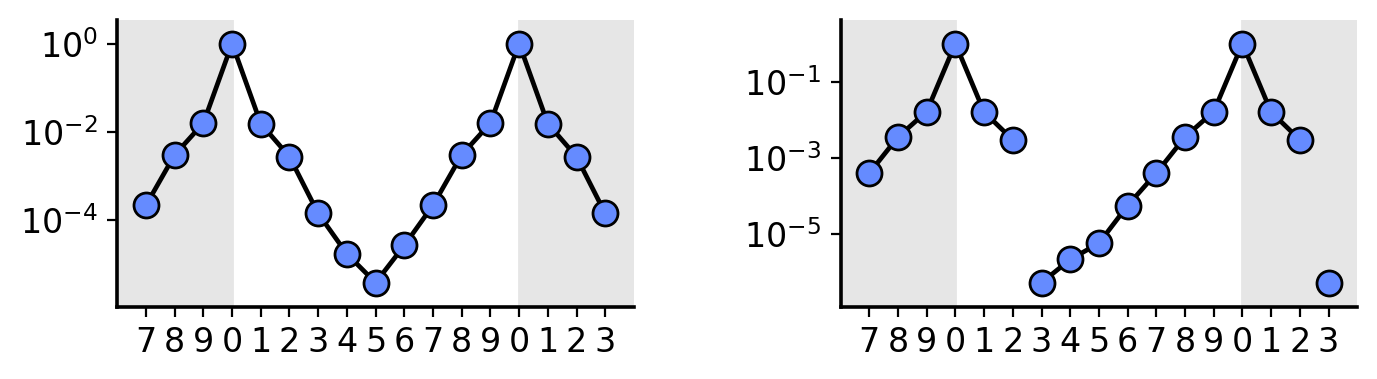

In [ ]:
log = logs[5]
M = log['weights']['M'][switch]
G = log['weights']['G'][switch]
goal_resp_before = get_goalc_resps_all_locs(M, G, [0], 
                                     sensory_input = {0: 1},
                                     adj_mat = adj_mat1,
                                     same_goal_cell = True)
goal_resp_before = goal_resp_before[[0,1,2,3,4,5,6,7,8,9]]
M = log['weights']['M'][-1]
G = log['weights']['G'][-1]
goal_resp_after = get_goalc_resps_all_locs(M, G, [0], 
                                     sensory_input = {0: 1},
                                     adj_mat = adj_mat2,
                                     same_goal_cell = True)
goal_resp_after = goal_resp_after[[0,1,10,11,4,5,6,7,8,9]]
# Plot
fig, axs = plt.subplots(figsize = (8,1.9), ncols = 2)
for nb, goal_resp in enumerate([goal_resp_before, goal_resp_after]):
  xs_label = [7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3]
  if nb == 0:
    axs[nb].plot(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
                 lw = 1.7,
                marker = 'o', markersize = 9, color = 'black',
                markerfacecolor = '#658BFF')
  if nb == 1:
    segs = ((0, 6), (6, 16), (16, 17))
    for (start, end) in segs:
      axs[nb].plot(np.arange(start, end), 
                   goal_resp.flatten()[xs_label[start:end]],
                   lw = 1.7,
                marker = 'o', markersize = 9, color = 'black',
                markerfacecolor = '#658BFF')
  # axs[nb].set_ylim(3e-2, 3)
  axs[nb].set_xticks(np.arange(len(xs_label)))
  axs[nb].set_xticklabels(xs_label)
  axs[nb].margins(y = 0.1)
  axs[nb].set_xlim(-1, 17)
  axs[nb].set_yscale('log')
  axs[nb].axvspan(-1, 3, color='0.9')
  axs[nb].axvspan(13, 18, color='0.9')
plt.subplots_adjust(wspace=0.4)
# plt.savefig('sim_logs/adapt_blockage_goalresp.pdf', bbox_inches='tight')

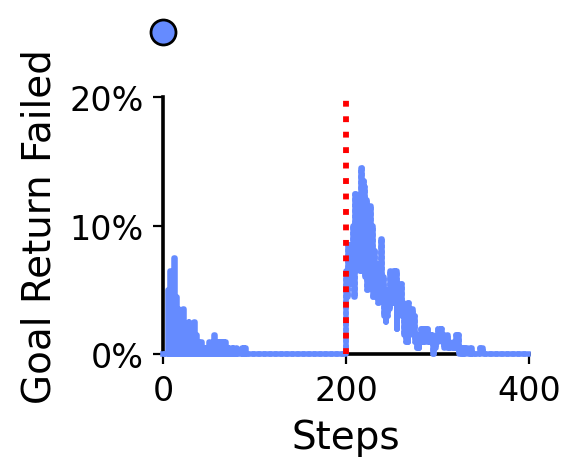

In [ ]:
# Plot ability to return to goal over steps
plot_return_to_goal_v_time_multirun(
    logs, 
    [adj_mat1, adj_mat2], [[0], [0]], 
    goal_names = ['reward'],
    goal_colors = ['#658BFF'],
    switch_config= [0, switch],
    goal_input_eff = [1, 1],
    figsize = (3,2.5),
    lw = 2)
plt.axvline(switch, lw = 2.1, ls = ":", c = 'red', zorder = 15)
plt.tight_layout()
plt.savefig('sim_logs/adapt_blockage.pdf')

### Shortcut

Exact reversal of blockage. Start blocked, then add point cells in prior locations that now get connected.

In [ ]:
# Build an adjacency matrix with n + 2 nodes, where the 2 extra nodes 
# will be used after blockage has started.

runs = 200
logs = []
for _ in range(runs):
  invalid_traj = True
  while invalid_traj:
    # only use trajectories that didn't get stuck at nodes 2-3 when dropped.
    traj = graph_randomwalk([adj_mat2, adj_mat1],
                            start_node = 0,
                            steps = [switch, 200])
    if 10 not in set(traj[switch:]) and 11 not in set(traj[switch:]):
      invalid_traj = False
  log = simulate_learning(
      traj,
      n_states = n_nodes + add_nodes,
      goal_cell_map = {0: 0}, # one goal
      n_goals = 1,
      switch_graph = [0, switch],
      adj_mat = [adj_mat2, adj_mat1]
      )
  logs.append(log)

|█████████████████████████| 100%

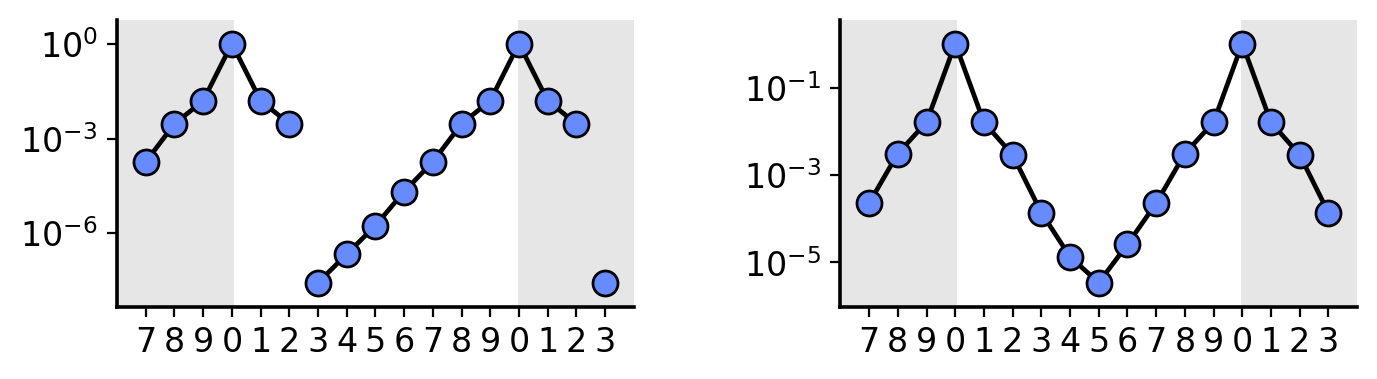

In [ ]:
log = logs[0]
M = log['weights']['M'][switch]
G = log['weights']['G'][switch]
goal_resp_before = get_goalc_resps_all_locs(M, G, [0], 
                                     sensory_input = {0: 1},
                                     adj_mat = adj_mat2,
                                     same_goal_cell = True)
goal_resp_before = goal_resp_before[[0,1,10,11,4,5,6,7,8,9]]
M = log['weights']['M'][-1]
G = log['weights']['G'][-1]
goal_resp_after = get_goalc_resps_all_locs(M, G, [0], 
                                     sensory_input = {0: 1},
                                     adj_mat = adj_mat1,
                                     same_goal_cell = True)
goal_resp_after = goal_resp_after[[0,1,2,3,4,5,6,7,8,9]]
# Plot
fig, axs = plt.subplots(figsize = (8,1.9), ncols = 2)
for nb, goal_resp in enumerate([goal_resp_before, goal_resp_after]):
  xs_label = [7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3]
  if nb == 1:
    axs[nb].plot(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
                 lw = 1.7,
                marker = 'o', markersize = 9, color = 'black',
                markerfacecolor = '#658BFF')
  elif nb == 0:
    segs = ((0, 6), (6, 16), (16, 17))
    for (start, end) in segs:
      axs[nb].plot(np.arange(start, end), 
                   goal_resp.flatten()[xs_label[start:end]],
                   lw = 1.7,
                marker = 'o', markersize = 9, color = 'black',
                markerfacecolor = '#658BFF')
  axs[nb].set_xticks(np.arange(len(xs_label)))
  axs[nb].set_xticklabels(xs_label)
  axs[nb].margins(y = 0.1)
  axs[nb].set_xlim(-1, 17)
  axs[nb].set_yscale('log')
  axs[nb].axvspan(-1, 3, color='0.9')
  axs[nb].axvspan(13, 18, color='0.9')
plt.subplots_adjust(wspace=0.4)
plt.savefig('sim_logs/adapt_shortcut_goalresp.pdf',
            bbox_inches='tight')

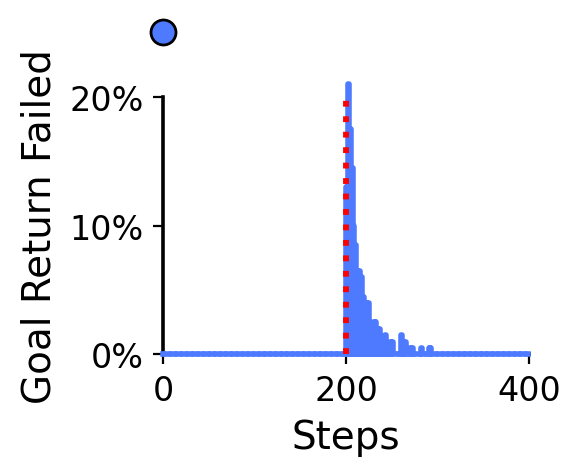

In [ ]:
# Plot ability to return to goal over steps
plot_return_to_goal_v_time_multirun(
    logs, 
    [adj_mat2, adj_mat1], [[0], [0]], 
    goal_names = ['reward'],
    goal_colors = ['#4E7AFF'], 
    switch_config=[0, switch],
    goal_input_eff = [1, 1],
    figsize = (3,2.5),
    lw = 2)
plt.axvline(switch, lw = 2.1, ls = ":", c = 'red', zorder=15)
plt.tight_layout()
plt.savefig('sim_logs/adapt_shortcut.pdf')

### Dual Reward (Equal)

In [ ]:
# Initialize ring graph
n_nodes = 10
adj_mat = np.zeros((n_nodes,n_nodes))
pairs = [(i,i+1) for i in range(n_nodes-1)] + [(n_nodes-1, 0)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1
# Compare 2 equal rewards and 2 different rewards
traj = pickle.load(open('sim_logs/ring_traj.p', 'rb'))
switch = 1000
log_equi = simulate_learning(
  traj,
  n_nodes,
  goal_cell_map = [{0: 0}, {0: 0, 5: 0}],
  goal_input_eff = [{0: 0.5}, {0: 0.5, 5: 0.5}],
  switch_graph = [0, switch],
  goal_corr_steps = [0, switch],
  adj_mat=[adj_mat, adj_mat],
  n_goals = 1)

|█████████████████████████| 100%

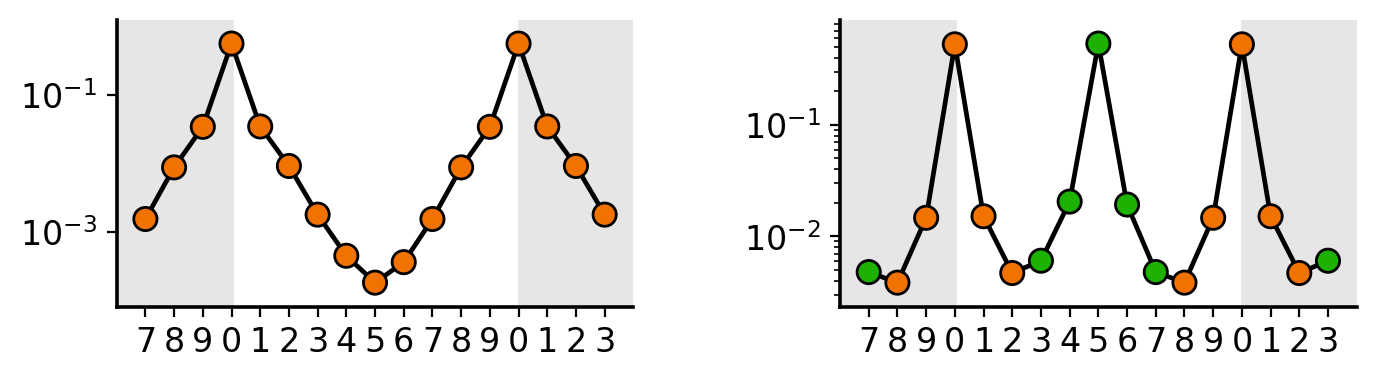

In [ ]:
M = log_equi['weights']['M'][switch]
G = log_equi['weights']['G'][switch]
goal_resp_equi = get_goalc_resps_all_locs(M, G,  [0], 
                                     sensory_input = {0: 0.5},
                                     adj_mat = adj_mat,
                                     same_goal_cell = True)
M = log_equi['weights']['M'][2000]
G = log_equi['weights']['G'][2000]
goal_resp_bias = get_goalc_resps_all_locs(M, G, [0, 5], 
                                     sensory_input = {0: 0.5, 5: 0.5},
                                     adj_mat = adj_mat,
                                     same_goal_cell = True)
# Plot
xs_label = [7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3]
colors = [['#F27200' for i in range(len(xs_label))],
          ['#1DB100'] +
          ['#F27200' for i in range(5)] +
          ['#1DB100' for i in range(5)] +
          ['#F27200' for i in range(5)] + 
          ['#1DB100']]
fig, axs = plt.subplots(figsize = (8, 1.9), ncols = 2, sharey = False)
for nb, goal_resp in enumerate([goal_resp_equi, goal_resp_bias]):
  axs[nb].plot(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
                lw = 1.7, color = 'black',
               zorder = 15)
  axs[nb].scatter(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
              marker = 'o', s = 70, edgecolor = 'black',
              c = colors[nb], zorder = 20)

  # axs[nb].set_ylim(3e-2, 3)
  axs[nb].set_xticks(np.arange(len(xs_label)))
  axs[nb].set_xticklabels(xs_label)
  axs[nb].margins(y = 0.1)
  axs[nb].set_xlim(-1, 17)
  axs[nb].set_yscale('log')
  axs[nb].axvspan(-1, 3, color='0.9')
  axs[nb].axvspan(13, 18, color='0.9')
plt.subplots_adjust(wspace=0.4)
plt.savefig('sim_logs/dualreward_newtarget.pdf',
            bbox_inches='tight')

### Dual Reward (Biased)

In [ ]:
# Initialize ring graph
n_nodes = 10
adj_mat = np.zeros((n_nodes,n_nodes))
pairs = [(i, i+1) for i in range(n_nodes-1)] + [(n_nodes-1, 0)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1
# Compare 2 equal rewards and 2 different rewards
traj = pickle.load(open('sim_logs/ring_traj.p', 'rb'))
alphas = [0.1, 0.01] # Adjust alphas if needed to see effect for different traj.
logs = []
for alpha in alphas:
  log = simulate_learning(
    traj,
    n_nodes,
    goal_cell_map = {0: 0, 5: 0},
    goal_input_eff = {0: 1, 5: 0.1},
    adj_mat = adj_mat,
    alpha = alpha,
    place_activity = 1,
    n_goals = 1)
  logs.append(log)

|█████████████████████████| 100%

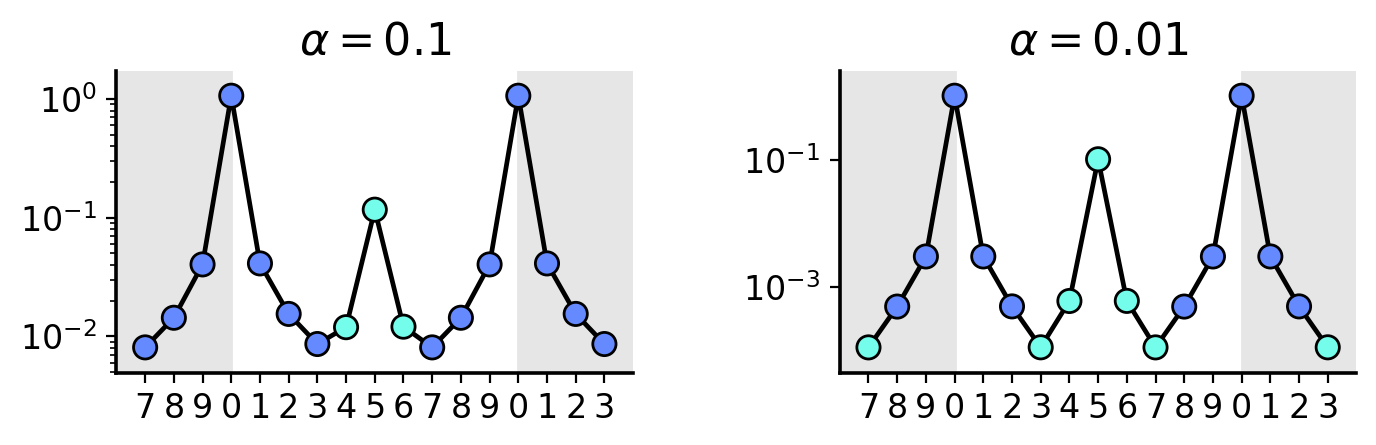

In [ ]:
i = 0
goal_resps = []
for log in logs[i*2:i*2+2]:
  M = log['weights']['M'][-1]
  G = log['weights']['G'][-1]
  goal_resp = get_goalc_resps_all_locs(M, G, [0, 5], 
                                      sensory_input = {0: 1, 5: 0.1},
                                      adj_mat = adj_mat,
                                      u_active = 1,
                                      same_goal_cell = True)
  goal_resps.append(goal_resp)

# Plot
xs_label = [7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3]
colors = [['#658AFF' for _ in range(7)] + 
           ['#73FDEA' for _ in range(3)] + 
           ['#658AFF' for _ in range(7)],
          ['#73FDEA'] + 
           ['#658AFF' for _ in range(5)] + 
           ['#73FDEA' for _ in range(5)] + 
           ['#658AFF' for _ in range(5)] + 
          ['#73FDEA']]
fig, axs = plt.subplots(figsize = (8, 2), ncols = 2, sharey = False)
for nb, goal_resp in enumerate(goal_resps):
  axs[nb].plot(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
                lw = 1.7, color = 'black',
               zorder = 15)
  axs[nb].scatter(np.arange(len(xs_label)), goal_resp.flatten()[xs_label],
              marker = 'o', s = 70, edgecolor = 'black',
              c = colors[nb], zorder = 20)
  axs[nb].set_xticks(np.arange(len(xs_label)))
  axs[nb].set_xticklabels(xs_label)
  axs[nb].margins(y = 0.1)
  axs[nb].set_xlim(-1, 17)
  axs[nb].set_yscale('log')
  axs[nb].axvspan(-1, 3, color='0.9')
  axs[nb].axvspan(13, 18, color='0.9')
  axs[nb].set_title(f"$\\alpha = {alphas[nb]}$")
plt.subplots_adjust(wspace=0.4)
plt.savefig('sim_logs/dualreward_bias_twoalphas.pdf',
            bbox_inches='tight')

## Supplementary

### Robustness to Oja's Params

In [ ]:
# Load saved experimental log
all_logs = pickle.load(
    open('sim_logs/oja_alpha_beta.p', 'rb'))
alphas = [0.16, 0.08, 0.04, 0.02, 0.002, 0.0002]
betas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
adj_mat = np.zeros((10,10))
pairs = [(0,1), (0,4), (1,2), (2,5), (3,4), (5,9), 
         (6,7), (6,3), (7,4), (7,8), (8,9)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1

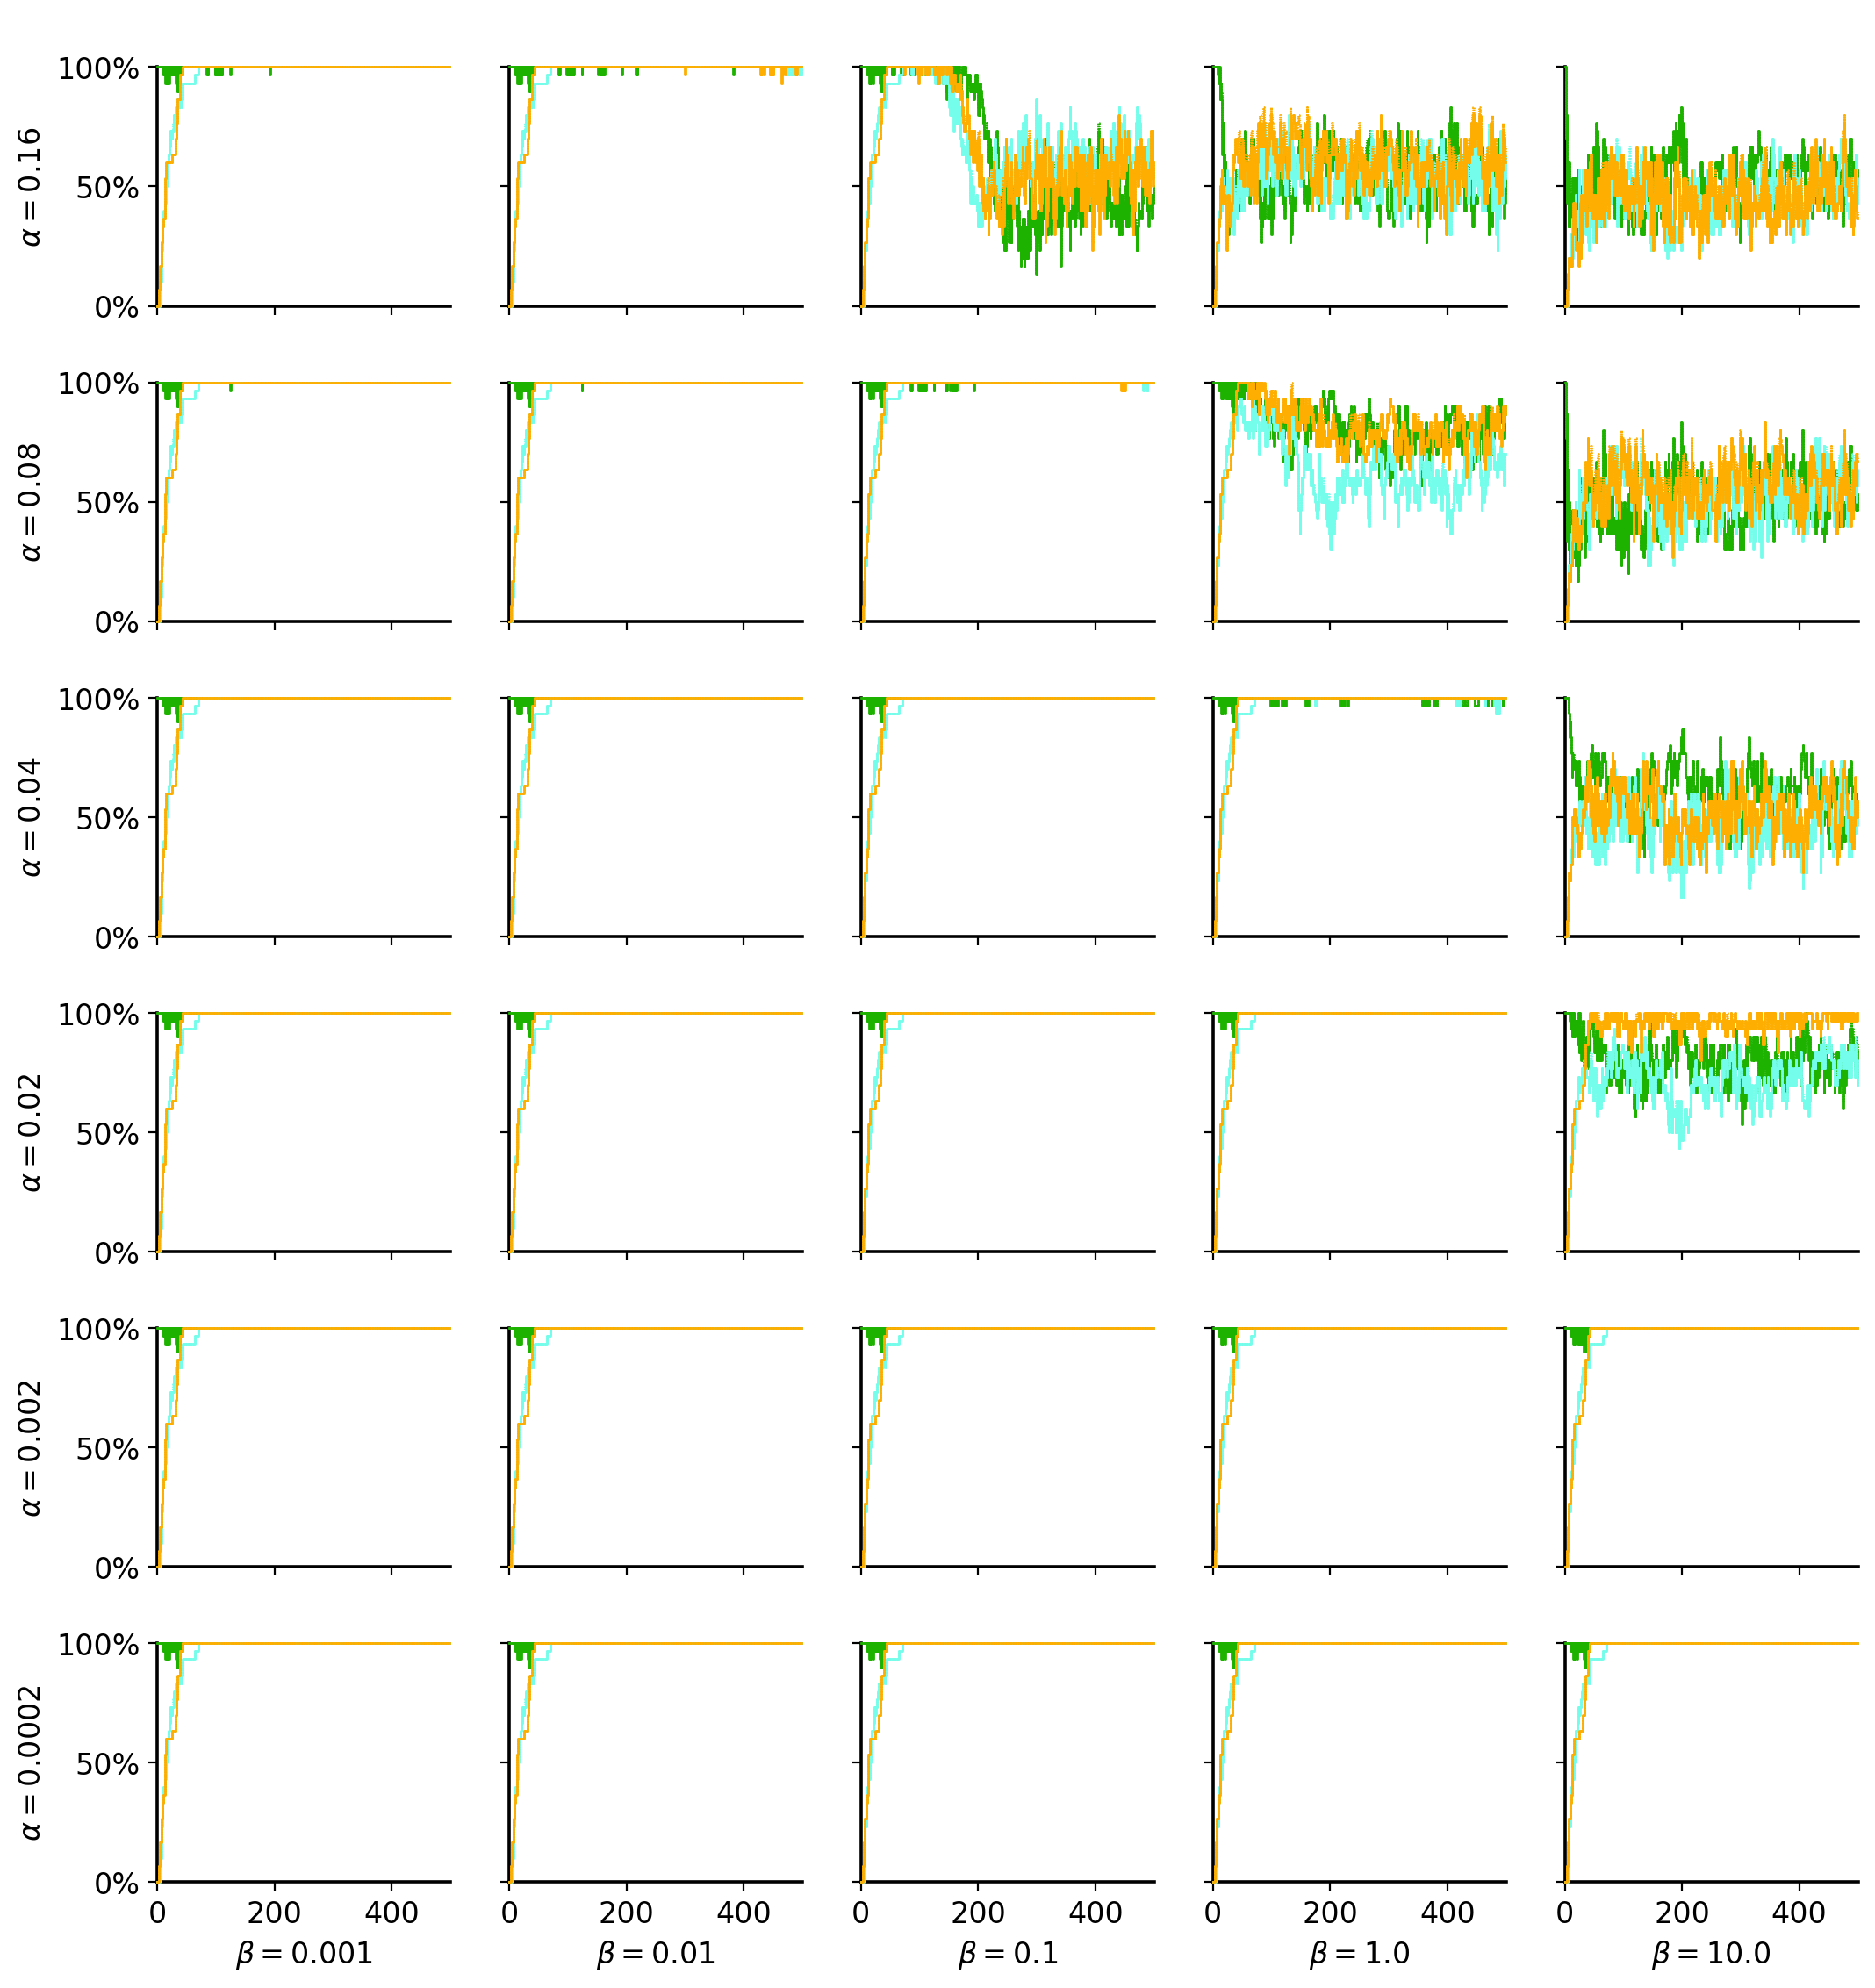

In [ ]:
# plot over hyperparam search

all_logs = fill_logs(all_logs)
fig, axs = plt.subplots(ncols = len(betas), nrows = 2 * len(alphas), 
                        figsize = (2.5 * len(betas), 2.3 * len(alphas)), 
                        sharex = True, sharey = 'row',
                        gridspec_kw={'height_ratios': len(alphas) * [0.1, 1]})
for nb, logs in enumerate(all_logs):
  plot_row = nb // len(betas)
  plot_col = nb % len(betas)
  plot_return_to_goal_v_time_multirun(logs, adj_mat, [6, 2, 9], 
                  ['Home', 'Water', 'Food'], 
                  ['#1DB100', '#73FDEA', '#FDAE00'],
                  axs = axs[plot_row*2:plot_row*2+2,plot_col], 
                  label = False, plot_error = False,
                  goal_reach_time_top = False)
  # label decay and noise param values
  beta = betas[plot_col]
  alpha = alphas[plot_row]
  if plot_col == 0:
    axs[plot_row*2+1, plot_col].set_ylabel(f'$\\alpha = {alpha}$', size = 12)
  if plot_row == len(alphas) - 1:
    axs[-1, plot_col].set_xlabel(f'$\\beta = {beta}$', size = 12)
# plt.savefig('sim_logs/oja_alpha_v_beta.pdf')

In [ ]:
# Code to re-run simulation from scratch (overwrites existing log)

# Gridworld Environment
adj_mat = np.zeros((10,10))
pairs = [(0,1), (0,4), (1,2), (2,5), (3,4), (5,9), 
         (6,7), (6,3), (7,4), (7,8), (8,9)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1

# Train model on trajectory
all_logs = []
runs = 30
# pre simulate trajectories
trajs = []
for _ in range(runs):
  traj = graph_randomwalk(adj_mat, steps = 5e2, start_node = 6)
  trajs.append(traj)
alphas = [0.16, 0.08, 0.04, 0.02, 0.002, 0.0002]
betas = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
for alpha in alphas:
  for beta in betas:
    repeat_logs = []
    for run in range(runs):
      # Gridworld
      traj = trajs[run]
      log = simulate_learning(
              traj,
              n_states = len(adj_mat),
              alpha = alpha,
              beta = beta,
              goal_cell_map = {6: 0, 2: 1, 9: 2}, # home, water, food
              n_goals = 3,
              adj_mat = adj_mat,
              goal_input_eff = 1,
              )
      repeat_logs.append(log)
    all_logs.append(repeat_logs)

_pickle_save(all_logs, 'sim_logs/', 'oja2_spatial_param_log')

### Robustness to Noise

In [ ]:
# Load saved experimental log

# Gridworld Environment
adj_mat = np.zeros((10,10))
pairs = [(0,1), (0,4), (1,2), (2,5), (3,4), (5,9), 
         (6,7), (6,3), (7,4), (7,8), (8,9)]
alphas = [0.16, 0.08, 0.04, 0.02, 0.002, 0.0002]
# alphas = [0.08, 0.04, 0.02, 0.002, 0.0002]
noise_vals = [0, 0.25, 0.5, 0.75, 1]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1
all_logs = pickle.load(open('sim_logs/oja_alpha_noise_lognormal.p', 'rb'))

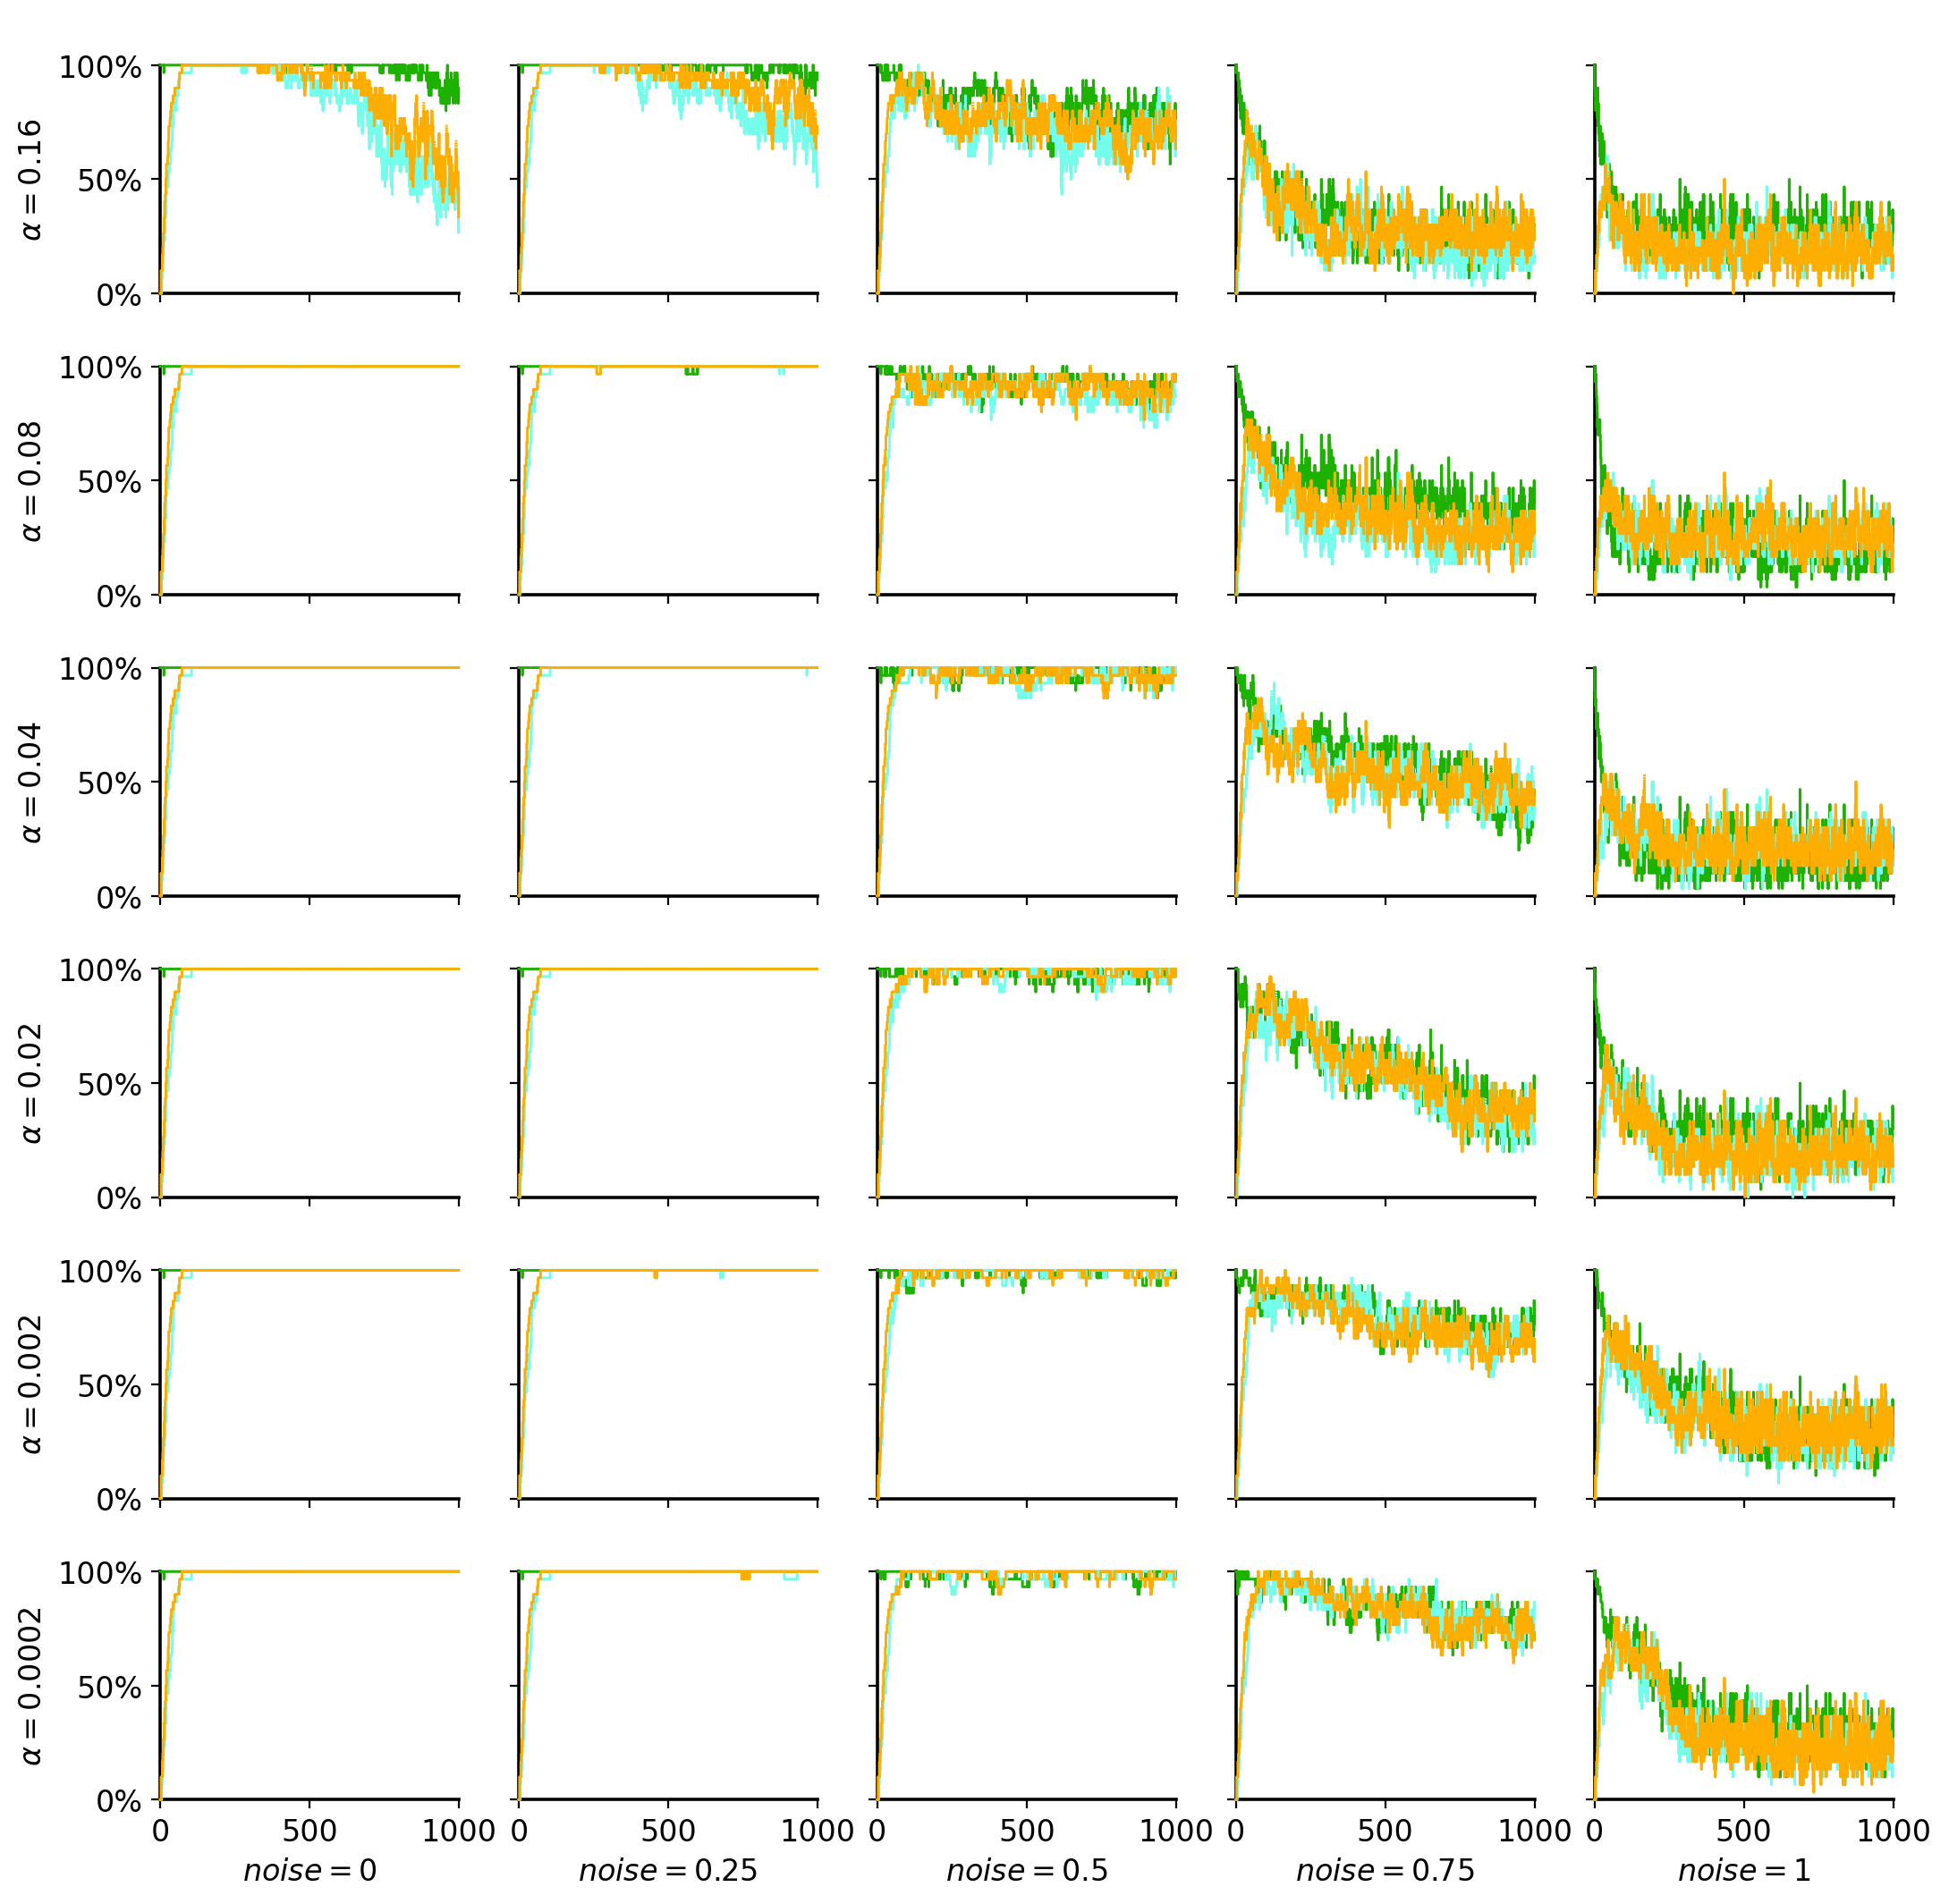

In [ ]:
# Plot alpha vs. noise levels
all_logs = fill_logs(all_logs)
row = alphas
cols = noise_vals
row_label = '\\alpha'
col_label = 'noise'
fig, axs = plt.subplots(ncols = len(cols), nrows = 2 * len(row), 
                        figsize = (2.5 * len(cols), 2.2 * len(row)), 
                        sharex = True, sharey = 'row',
                        gridspec_kw={'height_ratios': len(alphas) * [0.1, 1]})
for nb, logs in enumerate(all_logs):
  plot_row = nb // len(cols)
  plot_col = nb % len(cols)
  plot_return_to_goal_v_time_multirun(logs, adj_mat, [6, 2, 9], 
                  ['Home', 'Water', 'Food'], 
                  ['#1DB100', '#73FDEA', '#FDAE00'],
                  goal_reach_time_top = False,
                  axs = axs[plot_row*2:plot_row*2+2,plot_col], 
                  label = False, plot_error = False)
  # label decay and noise param values
  xlabel = cols[plot_col]
  ylabel = row[plot_row]
  if plot_col == 0:
    axs[plot_row*2+1, plot_col].set_ylabel(f'${row_label} = {ylabel}$', size = 12)
  if plot_row == len(row) - 1:
    axs[-1, plot_col].set_xlabel(f'${col_label} = {xlabel}$', size = 12)
plt.savefig('sim_logs/oja_alpha_v_noise_spatial.pdf')

In [ ]:
# Code to re-run simulation from scratch (overwrites existing log)

# Gridworld Environment
adj_mat = np.zeros((10,10))
pairs = [(0,1), (0,4), (1,2), (2,5), (3,4), (5,9), 
         (6,7), (6,3), (7,4), (7,8), (8,9)]
for n1, n2 in pairs:
  adj_mat[n1,n2] = adj_mat[n2,n1] = 1

# Train model on trajectory
all_logs = []
runs = 30
# pre simulate trajectories
trajs = []
for _ in range(runs):
  # traj = graph_randomwalk(adj_mat, steps = 2e2, start_node = 6)
  traj = graph_randomwalk(adj_mat, steps = 1e3, start_node = 6)
  trajs.append(traj)

alphas = [0.16, 0.08, 0.04, 0.02, 0.002, 0.0002]
# alphas = [0.08, 0.04, 0.02, 0.002, 0.0002]
noise_vals = [0, 0.25, 0.5, 0.75, 1]
for alpha in alphas:
  for noise in noise_vals:
    repeat_logs = []
    for run in range(runs):
      # Gridworld
      traj = trajs[run]
      log = simulate_learning(
          traj,
          n_states = len(adj_mat),
          goal_cell_map = {6: 0, 2: 1, 9: 2}, # home, water, food
          n_goals = 3,
          alpha = alpha,
          adj_mat = adj_mat,
          noise_sd_frac = noise,
          noise_lognormal = True)
      repeat_logs.append(log)
    all_logs.append(repeat_logs)

_pickle_save(all_logs, 'sim_logs/', 'oja_alpha_noise_lognormal')